# Marker Repo - annotation

In this notebook, clustered h5ad files can be annotated using the MarkerRepo or SCSA.

## Loading packages

In [47]:
import markerrepo.marker_repo as mr
import markerrepo.wrappers as wrap
import markerrepo.annotation as annot
import markerrepo.parsing as pars
import markerrepo.utils as utl
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import os
import inspect
import re
import math

#try:
#    from sctoolbox.tools import celltype_annotation
#except ModuleNotFoundError:
#    warnings.warn("Please install the latest sctoolbox version. Some functionality may not be available.", RuntimeWarning)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Settings

Specify path of the cloned repository and the h5ad file which is going to be annotated.

In [17]:
repo_path = "/mnt/workspace_stud/stud4/annotate_by_marker_and_features-sort"
h5ad_path = "/mnt/workspace_stud/allstud/wp1/data/2024_01_28/heart_lv_SM-IOBHO.h5ad" # heart_lv_SM-IOBHO.h5ad

Load anndata and list all possible settings.

In [18]:
adata = sc.read_h5ad(h5ad_path)
annot.list_possible_settings(repo_path, adata=adata)

Possible Settings:
----------------------------------------
1. Available columns to search in MarkerRepo:
  - List name
  - Organism name
  - Taxonomy ID
  - Marker type
  - Submitter name
  - List type
  - Source
  - tags_transferred
  - Date
  - Email
  - Tissue
  - Marker
  - Info

2. Possible organisms or taxon IDs:
  - human 9606
  - mouse 10090
  - zebrafish 7955
  - rat 10114
  - pig 9823
  - medaka 8090
  - chicken 9031
  - drosophila 7215
  - yeast 4932

3. Available columns in adata.obs:
  - n_genes_by_counts
  - log1p_n_genes_by_counts
  - total_counts
  - log1p_total_counts
  - cell type
  - ontology label
  - ontology id
  - nb_features
  - log_nb_features
  - lovain_0.1
  - lovain_0.25
  - lovain_0.5
  - lovain_1
  - leiden_0.1
  - leiden_0.25
  - leiden_0.5
  - leiden_1
  - kmeans_13
  - kmeans_16

4. Available columns in adata.var:
----------------------------------------


Enter general annotation settings.

In [20]:
# Taxonomy ID or Organism Name
# e.g., "human" or 9606
organism = "human"

# Column in .obs table where ranked genes groups are stored
# e.g., "rank_genes_groups"
# Enter None if no ranking has been performed yet
rank_genes_column = None

# Column in .var table where gene symbols or Ensembl IDs are stored
# Enter None if the index column of the .var table already has gene symbols or Ensembl IDs
# that you want to use for your annotation
genes_column = None

# The .obs table column of the clustering you want to annotate (e.g., "leiden" or "louvain")
# If None, you can pick one interactively 
clustering_column_lists = list(adata.uns["clusters"].keys())
#clustering_column_lists = ["lovain_0.1", "lovain_0.25", "lovain_0.5", "lovain_1", "leiden_0.1", "leiden_0.25", "leiden_0.5", "leiden_1", "kmeans_13", "kmeans_16"]

# Specify whether your index of the .var tables are Ensembl IDs (True) or gene symbols (False)
ensembl = mr.check_ensembl(adata)

# Name of the column to add with the final cell type annotation
# If None, all annotation columns will be kept
celltype_column_name = None

# Whether to delete the created marker lists after annotation or not
delete_lists = True

# 
column_specific_terms={"Source":"panglao", "Organism name":"human"}

# 
mr_parameters = [{"style":"two_column", "file_name":"two_column"}]

Validate general annotation settings and the mr_parameters.

In [21]:
def validate_settings(settings=None, repo_path=None, adata=None, organism=None, rank_genes_column=None, genes_column=None, 
                      clustering_column=None, ensembl=None, col_to_search=None, search_terms=None, column_specific_terms=None):
    """
    Validates user settings including file paths, anndata object columns, and specified organism.

    Parameters
    ----------
    settings : list of dict, default None
        A list of dictionaries, each containing parameters for 'create_marker_lists' function.
    repo_path : str, default None
        Path to the marker repository.
    adata : anndata.AnnData, default None
        The loaded AnnData object.
    organism : str or int, default None
        Organism name, taxon ID, or both. E.g., "mouse", 10090, or "mouse 10090".
    rank_genes_column : str, default None
        Column in .obs table where ranked genes are stored.
    genes_column : str, default None
        Column in .var table where gene symbols or IDs are stored.
    clustering_column : str, default None
        The column in .obs table of the clustering you want to annotate.
    ensembl : bool, default None
        Whether the genes in the genes_column are Ensembl IDs.
    col_to_search : str, default None
        Column to search in for marker list selection.
    search_terms : list of str, default None
        List of search terms to use for marker list selection.
    column_specific_terms : list of dicts, default None
        List of dictionaries with specific 'col_to_search' and 'search_terms' for each.

    Returns
    -------
    bool :
        Returns True if all settings are valid, otherwise prints the errors and returns False.
    """ 

    errors = []
    combined_df_columns = list(mr.combine_dfs(repo_path=repo_path).columns)
    utl.get_whitelists(repo_path=repo_path, silent_skip=True, update=False)

    # Validate settings dictionaries
    if settings:
        # Validate keys of dictionaries
        valid_params = set(param.name for param in inspect.signature(wrap.create_marker_lists).parameters.values())
        for setting in settings:
            invalid_params = set(setting) - valid_params
            if invalid_params:
                errors.append(f"Invalid parameters in settings: {', '.join(invalid_params)}")
        # Validate values of dictionaries
        if not invalid_params:
            for i, setting in enumerate(settings, 1):
                if "repo_path" in setting:
                    if not setting["repo_path"]:
                        errors.append(f"Settings for marker list {i}: No repo_path provided.")
                    else:
                        if not os.path.exists(setting["repo_path"]):
                            errors.append(f"Settings for marker list {i}: Repo path {setting['repo_path']} does not exist.")
                if "organism" in setting:
                    if not setting["organism"]:
                        errors.append(f"Settings for marker list {i}: No organism provided.")
                    else:
                        organism_str = str(setting["organism"]).strip()
                        is_valid_organism = any(organism_str == valid_entry.split(" ")[0] or organism_str == valid_entry.split(" ")[1] or organism_str == valid_entry for valid_entry in valid_organisms)
                        if not is_valid_organism:
                            formatted_valid_organisms = "\n  - " + "\n  - ".join(valid_organisms)
                            errors.append(f"Settings for marker list {i}: Invalid organism or taxon ID {setting['organism']}.\nAvailable options:{formatted_valid_organisms}\n")
                if "column_specific_terms" in setting:
                    if not setting["column_specific_terms"]:
                        errors.append(f"Settings for marker list {i}: No column specific terms provided.")
                    else:
                        for specific_column in setting["column_specific_terms"]:
                            if specific_column not in combined_df_columns:
                                formatted_combined_df_columns = "\n  - " + "\n  - ".join(combined_df_columns)
                                errors.append(f"Settings for marker list {i}: Invalid col_to_search {specific_column}.\nAvailable columns:{formatted_combined_df_columns}\n") 
                else:
                    if "col_to_search" in setting:
                        if not setting["col_to_search"]:
                            errors.append(f"Settings for marker list {i}: No col_to_search provided.")
                        else:
                            if setting["col_to_search"] not in combined_df_columns:
                                formatted_combined_df_columns = "\n  - " + "\n  - ".join(combined_df_columns)
                                errors.append(f"Settings for marker list {i}: Invalid col_to_search {setting['col_to_search']}.\nAvailable columns:{formatted_combined_df_columns}\n")
                    if "search_terms" in setting:
                        if not setting["search_terms"]:
                            errors.append(f"Settings for marker list {i}: No search_terms provided.")
                if "style" in setting:
                    if not setting["style"]:
                        errors.append(f"Settings for marker list {i}: No style provided.")
                    else:
                        if setting["style"] not in ["two_column", "score", "ui", "panglao"]:
                            errors.append(f"Settings for marker list {i}: Invalid style {setting['style']}. Available styles: two_column, score, ui, panglao")
                    
    # Validate individual parameters
    if repo_path and not os.path.exists(repo_path):
        errors.append(f"Repo path {repo_path} does not exist.")

    if adata is None:
        errors.append("No AnnData object provided.")
        
    # List of valid organisms and their tax IDs
    valid_organisms = utl.read_whitelist("organism", repo_path=repo_path)['whitelist']

    # Validate the organism
    if organism:
        organism_str = str(organism).strip()
        is_valid_organism = any(organism_str == valid_entry.split(" ")[0] or organism_str == valid_entry.split(" ")[1] or organism_str == valid_entry for valid_entry in valid_organisms)
        if not is_valid_organism:
            formatted_valid_organisms = "\n  - " + "\n  - ".join(valid_organisms)
            errors.append(f"Invalid organism or taxon ID {organism}.\nAvailable options:{formatted_valid_organisms}\n")

    # Validate obs and var columns
    if rank_genes_column and rank_genes_column not in adata.obs.columns:
        formatted_obs_columns = "\n  - " + "\n  - ".join(adata.obs.columns)
        errors.append(f"Invalid rank_genes_column {rank_genes_column}.\nAvailable columns in adata.obs:{formatted_obs_columns}\n")

    if genes_column and genes_column not in adata.var.columns:
        formatted_var_columns = "\n  - " + "\n  - ".join(adata.var.columns)
        errors.append(f"Invalid genes_column {genes_column}.\nAvailable columns in adata.var:{formatted_var_columns}\n")

#    if clustering_column and clustering_column not in adata.obs.columns:
#        formatted_obs_columns = "\n  - " + "\n  - ".join(adata.obs.columns)
#        errors.append(f"Invalid column {clustering_column}.\nAvailable columns in adata.obs:{formatted_obs_columns}\n")

    if isinstance(clustering_column, list):
        for column in clustering_column:
            if column and column not in adata.obs.columns:
                formatted_obs_columns = "\n  - " + "\n  - ".join(adata.obs.columns)
                errors.append(f"Invalid column {column}.\nAvailable columns in adata.obs:{formatted_obs_columns}\n")
    else:
        if clustering_column and clustering_column not in adata.obs.columns:
            formatted_obs_columns = "\n  - " + "\n  - ".join(adata.obs.columns)
            errors.append(f"Invalid column {clustering_column}.\nAvailable columns in adata.obs:{formatted_obs_columns}\n")    


    # Validate col_to_search and search_terms based on column_specific_terms if provided
    if column_specific_terms:
        for specific_column in column_specific_terms:
            if specific_column not in combined_df_columns:
                formatted_combined_df_columns = "\n  - " + "\n  - ".join(combined_df_columns)
                errors.append(f"Invalid col_to_search {specific_column}.\nAvailable columns:{formatted_combined_df_columns}\n")
    else:
        # Validate col_to_search using the columns from the combined DataFrames in the repo
        if col_to_search:
            if col_to_search not in combined_df_columns:
                formatted_combined_df_columns = "\n  - " + "\n  - ".join(combined_df_columns)
                errors.append(f"Invalid col_to_search {col_to_search}.\nAvailable columns:{formatted_combined_df_columns}\n")

    # Print errors or confirm validation
    if errors:
        print("Validation failed due to the following errors:")
        print("-" * 40)
        for error in errors:
            print(error)
        print("-" * 40)

        return False
    else:
        print("All settings are valid.")
        print(f"Summary of settings:")
        print("-" * 40)
        print("General parameters:")
        print(f"  Repo path: {repo_path}")
        print(f"  Organism: {organism}")
        print(f"  Rank genes column: {rank_genes_column}")
        print(f"  Genes column: {genes_column}")
        print(f"  Clustering column: {clustering_column}")
        print(f"  Ensembl IDs: {ensembl}")

        if column_specific_terms:
            print(f"  Column specific terms:")
            for i, specific_column in enumerate(column_specific_terms.keys()):
                print(f"    {i+1}. Column to search: {specific_column}, Search terms: {column_specific_terms[specific_column]}")
        else:
            print(f"  Column to search: {col_to_search}")
            print(f"  Search terms: {search_terms}")

        if settings:
            print("\nParameters from dictionary:")
            for i, setting in enumerate(settings, 1):
                print(f"  {i}. Marker list:")
                for key, value in setting.items():
                    print(f"    {key}: {value}")

        print("-" * 40)

    return True

In [22]:
validate_settings(settings=mr_parameters, repo_path=repo_path, adata=adata, organism=organism, 
                        rank_genes_column=rank_genes_column, genes_column=genes_column, clustering_column=clustering_column_lists, ensembl=ensembl,
                        column_specific_terms=column_specific_terms)

All settings are valid.
Summary of settings:
----------------------------------------
General parameters:
  Repo path: /mnt/workspace_stud/stud4/annotate_by_marker_and_features-sort
  Organism: human
  Rank genes column: None
  Genes column: None
  Clustering column: ['kmeans_13', 'kmeans_16', 'leiden_0.1', 'leiden_0.25', 'leiden_0.5', 'leiden_1', 'lovain_0.1', 'lovain_0.25', 'lovain_0.5', 'lovain_1']
  Ensembl IDs: False
  Column specific terms:
    1. Column to search: Source, Search terms: panglao
    2. Column to search: Organism name, Search terms: human

Parameters from dictionary:
  1. Marker list:
    style: two_column
    file_name: two_column
----------------------------------------


True

## Create suitable marker list(s)

<details>
    <summary>Click here to see/collapse the function description</summary>
    <p><b>Function Call:</b> create_multiple_marker_lists</p>
    <p>This function calls 'create_marker_lists' with multiple parameter sets to create marker lists. It iterates over each dictionary within a list, using its contents to call 'create_marker_lists'. Default values are assigned for any parameters missing from a dictionary, but these can be overridden by individual dictionary entries.</p>
    <p><b>Parameters (excerpt):</b></p>
    <ul>
        <li><b>settings:</b> list of dict, default [{}] - A list of dictionaries where each dictionary contains parameters for a single call to 'create_marker_lists'. Keys should match the parameter names of 'create_marker_lists', and values are the desired values for those parameters.</li>
        <li><b>style:</b> str, default "score" - Determines the style of the marker lists. Available options include "two_column", "score", "ui", and "panglao".</li>
        <li><b>force_homology:</b> bool, default False - If set to True, the function will attempt to create marker lists via homology, even if marker lists for the given organism already exist.</li>
        <li><b>show_lists:</b> bool, default True - If True, the function displays the marker lists of the query post-creation.</li>
        <li><b>column_specific_terms:</b> dict, default None - A dictionary with column names as keys and lists of search terms as values. If provided, this overrides the 'col_to_search' and 'search_terms' parameters.</li>
        <li><b>adata:</b> AnnData, default None - If provided, the function adds the marker list IDs to the .uns table of the AnnData object.</li>
    </ul>
    <p><b>Returns:</b></p>
    <ul>
        <li><b>list of str:</b> A list of all paths to the created marker lists.</li>
    </ul>
</details>


The paths of the marker lists will be stored in the <b>marker_lists</b> variable. They will work as input for the actual cell type annotation of the next cell.

In [23]:
marker_lists = wrap.create_multiple_marker_lists(settings=mr_parameters, repo_path=repo_path, organism=organism, 
                                                 ensembl=ensembl, column_specific_terms=column_specific_terms,
                                                 show_lists=True, adata=adata)

Found 85 marker lists for the given organism human.


List name Organism name Taxonomy ID  \
ID                                                                     
1688745545837              HCM_human_fetus         human        9606   
168874554211252         Panglao_human_skin         human        9606   
168874554264756        Panglao_human_lungs         human        9606   
168874554292179           Panglao_human_na         human        9606   
168874554338416   HCM_human_adipose-tissue         human        9606   
...                                    ...           ...         ...   
1688745545661137  HCM_human_fetal-striatum         human        9606   
1688745545683176      HCM_human_esophageal         human        9606   
1688745545764487         HCM_human_gingiva         human        9606   
1688745545897512   HCM_human_head-and-neck         human        9606   
1688745545951071            HCM_human_germ         human        9606   

                 Marker type            Submitter name             List type  \
ID                                                                             
1688745545837          Genes  Kessler, Micha Frederick  Cell type annotation   
168874554211252        Genes  Kessler, Micha Frederick  Cell type annotation   
168874554264756        Genes  Kessler, Micha Frederick  Cell type annotation   
168874554292179        Genes  Kessler, Micha Frederick  Cell type annotation   
168874554338416        Genes  Kessler, Micha Frederick  Cell type annotation   
...                      ...                       ...                   ...   
1688745545661137       Genes  Kessler, Micha Frederick  Cell type annotation   
1688745545683176       Genes  Kessler, Micha Frederick  Cell type annotation   
1688745545764487       Genes  Kessler, Micha Frederick  Cell type annotation   
1688745545897512       Genes  Kessler, Micha Frederick  Cell type annotation   
1688745545951071       Genes  Kessler, Micha Frederick  Cell type annotation   

                                               Source tags_transferred  \
ID                                                                       
1688745545837     bio-bigdata.hrbmu.edu.cn/CellMarker              NaN   
168874554211252                            panglao.se              NaN   
168874554264756                            panglao.se              NaN   
168874554292179                            panglao.se              NaN   
168874554338416   bio-bigdata.hrbmu.edu.cn/CellMarker              NaN   
...                                               ...              ...   
1688745545661137  bio-bigdata.hrbmu.edu.cn/CellMarker              NaN   
1688745545683176  bio-bigdata.hrbmu.edu.cn/CellMarker              NaN   
1688745545764487  bio-bigdata.hrbmu.edu.cn/CellMarker              NaN   
1688745545897512  bio-bigdata.hrbmu.edu.cn/CellMarker              NaN   
1688745545951071  bio-bigdata.hrbmu.edu.cn/CellMarker              NaN   

                        Date                                  Email  \
ID                                                                    
1688745545837     27.03.2020  Micha-Frederick.Kessler@mpi-bn.mpg.de   
168874554211252   27.03.2020  Micha-Frederick.Kessler@mpi-bn.mpg.de   
168874554264756   27.03.2020  Micha-Frederick.Kessler@mpi-bn.mpg.de   
168874554292179   27.03.2020  Micha-Frederick.Kessler@mpi-bn.mpg.de   
168874554338416   27.03.2020  Micha-Frederick.Kessler@mpi-bn.mpg.de   
...                      ...                                    ...   
1688745545661137  27.03.2020  Micha-Frederick.Kessler@mpi-bn.mpg.de   
1688745545683176  27.03.2020  Micha-Frederick.Kessler@mpi-bn.mpg.de   
1688745545764487  27.03.2020  Micha-Frederick.Kessler@mpi-bn.mpg.de   
1688745545897512  27.03.2020  Micha-Frederick.Kessler@mpi-bn.mpg.de   
1688745545951071  27.03.2020  Micha-Frederick.Kessler@mpi-bn.mpg.de   

                          Tissue  \
ID                                 
1688745545837              fetus   
168874554211252             skin   
168874554264756         

Found 30 marker lists for the given search terms.


List name Organism name Taxonomy ID  \
ID                                                                             
168874554211252                 Panglao_human_skin         human        9606   
168874554264756                Panglao_human_lungs         human        9606   
168874554292179                   Panglao_human_na         human        9606   
1688745542115122              Panglao_human_thymus         human        9606   
1688745542118741     Panglao_human_urinary-bladder         human        9606   
1688745542119139       Panglao_human_smooth-muscle         human        9606   
1688745542129286            Panglao_human_gi-tract         human        9606   
1688745542154410               Panglao_human_blood         human        9606   
1688745542183518          Panglao_human_epithelium         human        9606   
1688745542209850    Panglao_human_olfactory-system         human        9606   
1688745542246866         Panglao_human_vasculature         human        9606   
1688745542285910              Panglao_human_zygote         human        9606   
1688745542314427      Panglao_human_adrenal-glands         human        9606   
1688745542325477               Panglao_human_heart         human        9606   
1688745542409119             Panglao_human_thyroid         human        9606   
1688745542414846         Panglao_human_oral-cavity         human        9606   
1688745542513048               Panglao_human_liver         human        9606   
1688745542559365            Panglao_human_pancreas         human        9606   
1688745542609078               Panglao_human_brain         human        9606   
1688745542617262       Panglao_human_mammary-gland         human        9606   
1688745542627888     Panglao_human_skeletal-muscle         human        9606   
1688745542643955              Panglao_human_embryo         human        9606   
1688745542679837       Panglao_human_immune-system         human        9606   
1688745542716184              Panglao_human_kidney         human        9606   
1688745542738674                 Panglao_human_eye         human        9606   
1688745542746459   Panglao_human_connective-tissue         human        9606   
1688745542753544            Panglao_human_placenta         human        9606   
1688745542851542                Panglao_human_bone         human        9606   
1688745542891267  Panglao_human_parathyroid-glands         human        9606   
1688745542962927        Panglao_human_reproductive         human        9606   

                 Marker type            Submitter name             List type  \
ID                                                                             
168874554211252        Genes  Kessler, Micha Frederick  Cell type annotation   
168874554264756        Genes  Kessler, Micha Frederick  Cell type annotation   
168874554292179        Genes  Kessler, Micha Frederick  Cell type annotation   
1688745542115122       Genes  Kessler, Micha Frederick  Cell type annotation   
1688745542118741       Genes  Kessler, Micha Frederick  Cell type annotation   
1688745542119139       Genes  Kessler, Micha Frederick  Cell type annotation   
1688745542129286       Genes  Kessler, Micha Frederick  Cell type annotation   
1688745542154410       Genes  Kessler, Micha Frederick  Cell type annotation   
1688745542183518       Genes  Kessler, Micha Frederick  Cell type annotation   
1688745542209850       Genes  Kessler, Micha Frederick  Cell type annotation   
1688745542246866       Genes  Kessler, Micha Frederick  Cell type annotation   
1688745542285910       Genes  Kessler, Micha Frederick  Cell type annotation   
1688745542314427       Genes  Kessler, Micha Frederick  Cell type annotation   
1688745542325477       Genes  Kessler, Micha Frederick  Cell type annotation   
1688745542409119       Genes  Kessler, Micha Frederick  Cell type annotation   
1688745542414846       Genes  Kessler, Micha Frederick  Cell type annotation   
1688745542513048       Genes  Kessler, M

Preparing two column style marker list...
Marker list saved: /mnt/workspace_stud/stud4/annotate_by_marker_and_features-sort/myCodes/two_column


## Annotate adata using the created list(s)

Show new annotation column.

In [24]:
def show_tables(annotation_dir=None, n=5, clustering_column="leiden_0.1", show_diff=True):
    """
    Display dataframes for each cluster showing scores, hits, number of genes, mean of UI. Optionally, 
    it can also show both normal and scaled normalized differences of every potential cell type.

    For each cluster, this function reads the corresponding file, sorts the cell types based on their scores.
    If show_diff is True, it calculates both normal and scaled normalized differences between each cell type 
    and its immediate successor, and then displays the dataframe with these additional columns.

    Parameters
    ----------
    annotation_dir : string, default None
        The directory path where the annotation files are stored.
    n : int, default 5
        The maximum number of rows to display for each cluster.
    clustering_column : string, default "leiden_0.1"
        The clustering column used for cell type annotation.
    show_diff : bool, default False
        Whether to show the normalized differences in the output.
    """
    cluster_dict = {}

    path = f'{annotation_dir}/ranked/output/{clustering_column}/ranks'

    files = os.listdir(path)
    for file in files:
        cluster = file.split("_")[1]
        ct_column = f"Cluster {cluster}"
        df = pd.read_csv(f'{path}/{file}', sep='\t', names=[ct_column, "Score", "Hits", "Number of marker genes", "Mean of UI"])

        #df = df.sort_values(by='Score', ascending=False).reset_index(drop=True)

        if show_diff:
            # Calculate and add both normal and scaled diffs to the DataFrame if show_diff is True
            normal_diffs, scaled_diffs = annot.calculate_normalized_diffs(df.rename(columns={ct_column: "Cell type"}))
            df['Normalized Diff'] = df[ct_column].apply(lambda x: normal_diffs.get(x, 0))
            df['Scaled Diff'] = df[ct_column].apply(lambda x: scaled_diffs.get(x, 0))

        cluster_dict[ct_column] = df.head(n)
        display(df.head(n))

    return cluster_dict

In [25]:
def run_annotation(adata, marker_repo=True, SCSA=True, marker_lists=None, mr_obs="mr", scsa_obs="scsa", 
                   rank_genes_column=None, clustering_column=None, reference_obs=None, keep_all=False, 
                   verbose=False, show_ct_tables=False, show_plots=False, show_comparison=False, ignore_overwrite=True,
                   celltype_column_name=None):
    """
    Performs annotations on single cell data and allows the user to choose between different annotation methods. 

    Parameters
    ----------
    adata : AnnData
        The anndata object to annotate.
    marker_repo : bool, default True
        Whether to use Marker Repo annotation.
    SCSA : bool, default True
        Whether to use SCSA annotation.
    marker_lists : list of str, default []
        Paths to marker list files.
    mr_obs : str, default "mr"
        .obs key for Marker Repo annotation.
    scsa_obs : str, default "scsa"
        .obs key for SCSA annotation.
    rank_genes_column : str, default None
        The column of the .uns table which contains the rank genes scores. E.g. "rank_genes_groups". 
        If None, the ranking will be performed on the clustering_column.
    clustering_column : str, default None
        The column of the .obs table which contains the clustering information. E.g. "louvain" or "leiden".
    reference_obs : str, default None
        A reference annotation already present in the .obs table that can be compared with the other annotations.
    keep_all : bool, default False
        If True, all annotation columns will be kept. If False, only the selected annotation column and the reference_obs will be kept.
    verbose : bool, default False
        If True, the function will print additional information.
    show_ct_tables : bool, default False
        If True, the function will show the tables of the annotation.
    show_plots : bool, default False
        If True, the function will show the plots of the annotation.
    show_comparison : bool, default False
        If True, the function will show the comparison of the annotations.
    ignore_overwrite : bool, default False
        If True, the function will not ask for confirmation before overwriting existing files.
    celltype_column_name : str, default None
        The name of the selected cell type annotation column. If None, all annotation columns will be kept.
    """

    if not marker_repo and not SCSA:
        raise ValueError("At least one of 'marker_repo' or 'SCSA' must be True.")

    if marker_lists is None or not marker_lists:
        raise ValueError("No marker lists provided. Please provide a list of marker list paths.")
    
    for marker_list in marker_lists:
        if not os.path.exists(marker_list):
            raise FileNotFoundError(f"Marker list file not found: {marker_list}")
        
    if not clustering_column:
        clustering_column = mr.select(whitelist=list(adata.obs.columns), heading="clustering column")

    if clustering_column not in adata.obs:
        raise ValueError(f"Clustering column '{clustering_column}' not found in adata.obs.")

    if rank_genes_column is not None and rank_genes_column not in adata.uns:
        raise ValueError(f"Rank genes column '{rank_genes_column}' not found in adata.uns.")

    if reference_obs is not None and reference_obs not in adata.obs:
        raise ValueError(f"Reference annotation column '{reference_obs}' not found in adata.obs.")
    
    if not rank_genes_column:
        rank_genes_column = wrap.rank_genes(adata, clustering_column, show_plots=show_plots, verbose=verbose)

    annotation_columns = [] if reference_obs is None else [reference_obs]        

    for marker_list in marker_lists:
        name = marker_list.split('/')[-1]
        annotation_dir = f"./annotation/{name}"
        plot_columns = [] if reference_obs is None else [reference_obs]

        if marker_repo:
            ct_column = f"{mr_obs}_{name}"
            annotation_columns.append(ct_column)
            plot_columns.append(ct_column)
            
            # Execute Marker Repo annotation
            annot.annot_ct(adata, output_path=annotation_dir, db_path=marker_list,
                           cluster_column=clustering_column, rank_genes_column=rank_genes_column, 
                           ct_column=ct_column, verbose=verbose, ignore_overwrite=ignore_overwrite)

            # Show tables and alternative cell types of each cluster
            if show_ct_tables:
                print(f"Tables of cell type annotation with clustering {clustering_column} and marker list {name}:")
                #annot.show_tables(annotation_dir=annotation_dir, n=5, clustering_column=clustering_column, show_diff=True)
                show_tables(annotation_dir=annotation_dir, n=5, clustering_column=clustering_column, show_diff=True)

        if SCSA:
            column_added = f"{scsa_obs}_{name}"
            annotation_columns.append(column_added)
            plot_columns.append(column_added)

            # Execute SCSA annotation
            if verbose:
                celltype_annotation.run_scsa(adata, 
                    gene_column=None, 
                    key=rank_genes_column, 
                    column_added=column_added,
                    inplace=True, 
                    species=None, 
                    fc=1.5, 
                    pvalue=0.05, 
                    user_db=annot.reformat_marker_list(marker_list), 
                    celltype_column="cell_name")
            else:
                with wrap.suppress_logging(logger_name='sctoolbox'):
                    celltype_annotation.run_scsa(adata, 
                        gene_column=None, 
                        key=rank_genes_column, 
                        column_added=column_added,
                        inplace=True, 
                        species=None, 
                        fc=1.5, 
                        pvalue=0.05, 
                        user_db=annot.reformat_marker_list(marker_list), 
                        celltype_column="cell_name")

        umap_plot_file = f"{clustering_column}.png"

        # Show plots
        if show_plots:
            sc.pl.umap(adata, color=column, wspace=0.5, cmap=None, save=umap_plot_file)

    # Compare annotations
    if show_comparison:
        print("Comparison of cell type annotations:")

        
        display(annot.compare_cell_types(adata, clustering_column, annotation_columns))
    
    # Select cell type annotation
    if celltype_column_name:
        annotation_column = mr.select(whitelist=annotation_columns, heading="Select cell type annotation column:")
        adata.obs.rename(columns={annotation_column: celltype_column_name}, inplace=True)
    else:
        keep_all = True

    if not keep_all:
        # Keep only the selected annotation column and reference_obs if provided
        columns_to_keep = [annotation_column]
        if reference_obs is not None and reference_obs in adata.obs.columns:
            columns_to_keep.append(reference_obs)

        columns_to_remove = [col for col in annotation_columns if col not in columns_to_keep]
        adata.obs.drop(columns=columns_to_remove, inplace=True)

    return clustering_column, annot.compare_cell_types(adata, clustering_column, annotation_columns), umap_plot_file, show_tables(annotation_dir=annotation_dir, n=5, clustering_column=clustering_column, show_diff=True)


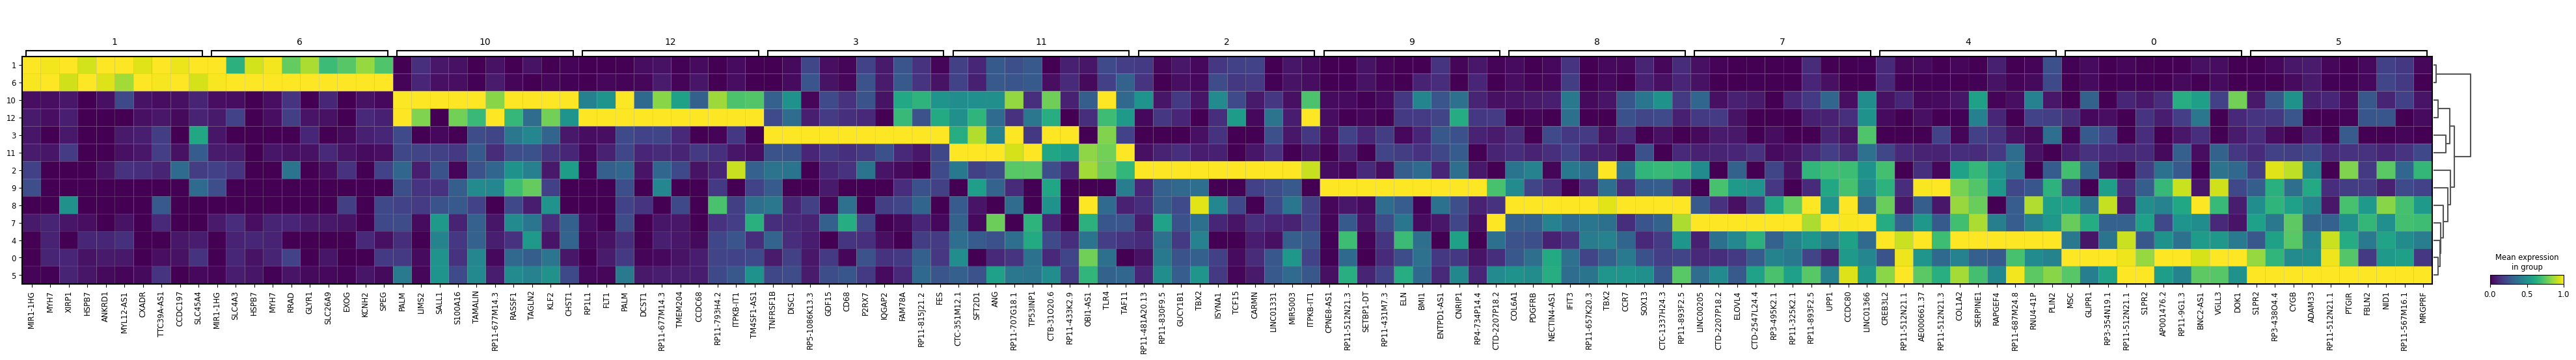

Tables of cell type annotation with clustering kmeans_13 and marker list two_column:


Cluster 6  Score  Hits  Number of marker genes  Mean of UI  \
0       Cardiomyocytes     48    61                     107           1   
1             Myocytes     23    32                      89           1   
2  Smooth muscle cells     19    28                      81           1   
3              Neurons     18    57                     205           1   
4      Enteric neurons     16    22                      68           1   

   Normalized Diff  Scaled Diff  
0         0.520833          100  
1         0.173913           33  
2         0.052632           10  
3         0.111111           21  
4         0.062500           12

Cluster 12  Score  Hits  Number of marker genes  Mean of UI  \
0          Endothelial cells      5    50                     194           1   
1  Endothelial cells (aorta)      4    28                      89           1   
2              Stromal cells      3    11                      36           1   
3                  Platelets      3    28                     131           1   
4                Fibroblasts      3    35                     176           1   

   Normalized Diff  Scaled Diff  
0         0.200000           20  
1         0.250000           25  
2         0.000000            0  
3         0.000000            0  
4         0.333333           33

Cluster 1  Score  Hits  Number of marker genes  Mean of UI  \
0       Cardiomyocytes     12    54                     107           1   
1             Myocytes      6    25                      89           1   
2  Smooth muscle cells      5    23                      81           1   
3              Neurons      4    45                     205           1   
4       Myofibroblasts      3     5                       9           1   

   Normalized Diff  Scaled Diff  
0         0.500000          100  
1         0.166667           33  
2         0.200000           40  
3         0.250000           50  
4         0.000000            0

Cluster 5  Score  Hits  Number of marker genes  Mean of UI  \
0                Fibroblasts     19    71                     176           1   
1  Pancreatic stellate cells     15    17                      29           1   
2     Hepatic stellate cells     14    22                      45           1   
3                 Adipocytes     12    38                     121           1   
4                  Pericytes     11    23                      62           1   

   Normalized Diff  Scaled Diff  
0         0.210526           42  
1         0.066667           13  
2         0.142857           29  
3         0.083333           17  
4         0.090909           18

Cluster 11  Score  Hits  Number of marker genes  Mean of UI  \
0           Stromal cells      1     8                      36           1   
1               Tanycytes      1     5                      26           1   
2  Hepatic stellate cells      1     8                      45           1   
3     Smooth muscle cells      1    12                      81           1   
4               Pericytes      1     9                      62           1   

   Normalized Diff  Scaled Diff  
0              0.0            0  
1              0.0            0  
2              0.0            0  
3              0.0            0  
4              0.0            0

Cluster 8  Score  Hits  Number of marker genes  Mean of UI  \
0                Fibroblasts      4    51                     176           1   
1  Pancreatic stellate cells      3    12                      29           1   
2     Hepatic stellate cells      3    15                      45           1   
3                  Podocytes      2    32                      98           1   
4  Endothelial cells (aorta)      2    25                      89           1   

   Normalized Diff  Scaled Diff  
0         0.250000           25  
1         0.000000            0  
2         0.333333           33  
3         0.000000            0  
4         0.000000            0

Cluster 2  Score  Hits  Number of marker genes  Mean of UI  \
0     Hepatic stellate cells      6    22                      45           1   
1            Mesangial cells      6    23                      59           1   
2                  Pericytes      6    21                      62           1   
3  Pancreatic stellate cells      5    11                      29           1   
4                Fibroblasts      5    46                     176           1   

   Normalized Diff  Scaled Diff  
0         0.000000            0  
1         0.000000            0  
2         0.166667           17  
3         0.000000            0  
4         0.000000            0

Cluster 0  Score  Hits  Number of marker genes  Mean of UI  \
0                Fibroblasts      6    56                     176           1   
1  Pancreatic stellate cells      4    14                      29           1   
2     Hepatic stellate cells      4    20                      45           1   
3                 Adipocytes      4    30                     121           1   
4  Endothelial cells (aorta)      3    28                      89           1   

   Normalized Diff  Scaled Diff  
0         0.333333           33  
1         0.000000            0  
2         0.000000            0  
3         0.250000           25  
4         0.000000            0

Cluster 7  Score  Hits  Number of marker genes  Mean of UI  \
0                Fibroblasts      5    49                     176           1   
1  Pancreatic stellate cells      4    13                      29           1   
2     Hepatic stellate cells      4    17                      45           1   
3            Mesangial cells      3    17                      59           1   
4  Endothelial cells (aorta)      3    24                      89           1   

   Normalized Diff  Scaled Diff  
0             0.20           20  
1             0.00            0  
2             0.25           25  
3             0.00            0  
4             0.00            0

Cluster 3  Score  Hits  Number of marker genes  Mean of UI  \
0               Osteoclasts      3    11                      52           1   
1  Hematopoietic stem cells      3    15                      91           1   
2                 Microglia      3    11                      72           1   
3               Macrophages      3    20                     134           1   
4                 Monocytes      3    10                     103           1   

   Normalized Diff  Scaled Diff  
0         0.000000            0  
1         0.000000            0  
2         0.000000            0  
3         0.000000            0  
4         0.333333           33

Cluster 9  Score  Hits  Number of marker genes  Mean of UI  \
0                  Pericytes      2    18                      62           1   
1                Fibroblasts      2    40                     176           1   
2  Pancreatic stellate cells      1    10                      29           1   
3     Hepatic stellate cells      1    13                      45           1   
4                Crypt cells      1     5                      18           1   

   Normalized Diff  Scaled Diff  
0              0.0            0  
1              0.5           50  
2              0.0            0  
3              0.0            0  
4              0.0            0

Cluster 10  Score  Hits  Number of marker genes  \
0                Endothelial cells      6    51                     194   
1                      Fibroblasts      5    41                     176   
2        Endothelial cells (aorta)      4    22                      89   
3                        Platelets      4    28                     131   
4  Pulmonary alveolar type I cells      3    13                      35   

   Mean of UI  Normalized Diff  Scaled Diff  
0           1         0.166667           17  
1           1         0.200000           20  
2           1         0.000000            0  
3           1         0.250000           25  
4           1         0.000000            0

Cluster 4  Score  Hits  Number of marker genes  Mean of UI  \
0                Fibroblasts      5    52                     176           1   
1  Pancreatic stellate cells      3    10                      29           1   
2     Hepatic stellate cells      3    14                      45           1   
3                  Pericytes      3    17                      62           1   
4                 Adipocytes      3    30                     121           1   

   Normalized Diff  Scaled Diff  
0              0.4           40  
1              0.0            0  
2              0.0            0  
3              0.0            0  
4              0.0            0

/home/stud4/.conda/envs/marker-repo-sort/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


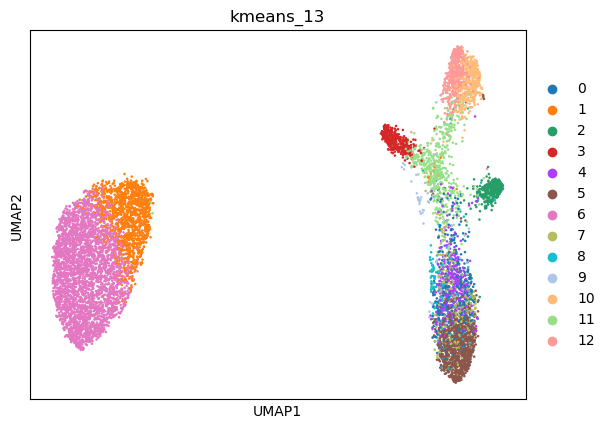

Comparison of cell type annotations:


mr_two_column
kmeans_13                        
0                     Fibroblasts
1                  Cardiomyocytes
2          Hepatic stellate cells
3                     Osteoclasts
4                     Fibroblasts
5                     Fibroblasts
6                  Cardiomyocytes
7                     Fibroblasts
8                     Fibroblasts
9                       Pericytes
10              Endothelial cells
11                  Stromal cells
12              Endothelial cells

Cluster 6  Score  Hits  Number of marker genes  Mean of UI  \
0       Cardiomyocytes     48    61                     107           1   
1             Myocytes     23    32                      89           1   
2  Smooth muscle cells     19    28                      81           1   
3              Neurons     18    57                     205           1   
4      Enteric neurons     16    22                      68           1   

   Normalized Diff  Scaled Diff  
0         0.520833          100  
1         0.173913           33  
2         0.052632           10  
3         0.111111           21  
4         0.062500           12

Cluster 12  Score  Hits  Number of marker genes  Mean of UI  \
0          Endothelial cells      5    50                     194           1   
1  Endothelial cells (aorta)      4    28                      89           1   
2              Stromal cells      3    11                      36           1   
3                  Platelets      3    28                     131           1   
4                Fibroblasts      3    35                     176           1   

   Normalized Diff  Scaled Diff  
0         0.200000           20  
1         0.250000           25  
2         0.000000            0  
3         0.000000            0  
4         0.333333           33

Cluster 1  Score  Hits  Number of marker genes  Mean of UI  \
0       Cardiomyocytes     12    54                     107           1   
1             Myocytes      6    25                      89           1   
2  Smooth muscle cells      5    23                      81           1   
3              Neurons      4    45                     205           1   
4       Myofibroblasts      3     5                       9           1   

   Normalized Diff  Scaled Diff  
0         0.500000          100  
1         0.166667           33  
2         0.200000           40  
3         0.250000           50  
4         0.000000            0

Cluster 5  Score  Hits  Number of marker genes  Mean of UI  \
0                Fibroblasts     19    71                     176           1   
1  Pancreatic stellate cells     15    17                      29           1   
2     Hepatic stellate cells     14    22                      45           1   
3                 Adipocytes     12    38                     121           1   
4                  Pericytes     11    23                      62           1   

   Normalized Diff  Scaled Diff  
0         0.210526           42  
1         0.066667           13  
2         0.142857           29  
3         0.083333           17  
4         0.090909           18

Cluster 11  Score  Hits  Number of marker genes  Mean of UI  \
0           Stromal cells      1     8                      36           1   
1               Tanycytes      1     5                      26           1   
2  Hepatic stellate cells      1     8                      45           1   
3     Smooth muscle cells      1    12                      81           1   
4               Pericytes      1     9                      62           1   

   Normalized Diff  Scaled Diff  
0              0.0            0  
1              0.0            0  
2              0.0            0  
3              0.0            0  
4              0.0            0

Cluster 8  Score  Hits  Number of marker genes  Mean of UI  \
0                Fibroblasts      4    51                     176           1   
1  Pancreatic stellate cells      3    12                      29           1   
2     Hepatic stellate cells      3    15                      45           1   
3                  Podocytes      2    32                      98           1   
4  Endothelial cells (aorta)      2    25                      89           1   

   Normalized Diff  Scaled Diff  
0         0.250000           25  
1         0.000000            0  
2         0.333333           33  
3         0.000000            0  
4         0.000000            0

Cluster 2  Score  Hits  Number of marker genes  Mean of UI  \
0     Hepatic stellate cells      6    22                      45           1   
1            Mesangial cells      6    23                      59           1   
2                  Pericytes      6    21                      62           1   
3  Pancreatic stellate cells      5    11                      29           1   
4                Fibroblasts      5    46                     176           1   

   Normalized Diff  Scaled Diff  
0         0.000000            0  
1         0.000000            0  
2         0.166667           17  
3         0.000000            0  
4         0.000000            0

Cluster 0  Score  Hits  Number of marker genes  Mean of UI  \
0                Fibroblasts      6    56                     176           1   
1  Pancreatic stellate cells      4    14                      29           1   
2     Hepatic stellate cells      4    20                      45           1   
3                 Adipocytes      4    30                     121           1   
4  Endothelial cells (aorta)      3    28                      89           1   

   Normalized Diff  Scaled Diff  
0         0.333333           33  
1         0.000000            0  
2         0.000000            0  
3         0.250000           25  
4         0.000000            0

Cluster 7  Score  Hits  Number of marker genes  Mean of UI  \
0                Fibroblasts      5    49                     176           1   
1  Pancreatic stellate cells      4    13                      29           1   
2     Hepatic stellate cells      4    17                      45           1   
3            Mesangial cells      3    17                      59           1   
4  Endothelial cells (aorta)      3    24                      89           1   

   Normalized Diff  Scaled Diff  
0             0.20           20  
1             0.00            0  
2             0.25           25  
3             0.00            0  
4             0.00            0

Cluster 3  Score  Hits  Number of marker genes  Mean of UI  \
0               Osteoclasts      3    11                      52           1   
1  Hematopoietic stem cells      3    15                      91           1   
2                 Microglia      3    11                      72           1   
3               Macrophages      3    20                     134           1   
4                 Monocytes      3    10                     103           1   

   Normalized Diff  Scaled Diff  
0         0.000000            0  
1         0.000000            0  
2         0.000000            0  
3         0.000000            0  
4         0.333333           33

Cluster 9  Score  Hits  Number of marker genes  Mean of UI  \
0                  Pericytes      2    18                      62           1   
1                Fibroblasts      2    40                     176           1   
2  Pancreatic stellate cells      1    10                      29           1   
3     Hepatic stellate cells      1    13                      45           1   
4                Crypt cells      1     5                      18           1   

   Normalized Diff  Scaled Diff  
0              0.0            0  
1              0.5           50  
2              0.0            0  
3              0.0            0  
4              0.0            0

Cluster 10  Score  Hits  Number of marker genes  \
0                Endothelial cells      6    51                     194   
1                      Fibroblasts      5    41                     176   
2        Endothelial cells (aorta)      4    22                      89   
3                        Platelets      4    28                     131   
4  Pulmonary alveolar type I cells      3    13                      35   

   Mean of UI  Normalized Diff  Scaled Diff  
0           1         0.166667           17  
1           1         0.200000           20  
2           1         0.000000            0  
3           1         0.250000           25  
4           1         0.000000            0

Cluster 4  Score  Hits  Number of marker genes  Mean of UI  \
0                Fibroblasts      5    52                     176           1   
1  Pancreatic stellate cells      3    10                      29           1   
2     Hepatic stellate cells      3    14                      45           1   
3                  Pericytes      3    17                      62           1   
4                 Adipocytes      3    30                     121           1   

   Normalized Diff  Scaled Diff  
0              0.4           40  
1              0.0            0  
2              0.0            0  
3              0.0            0  
4              0.0            0

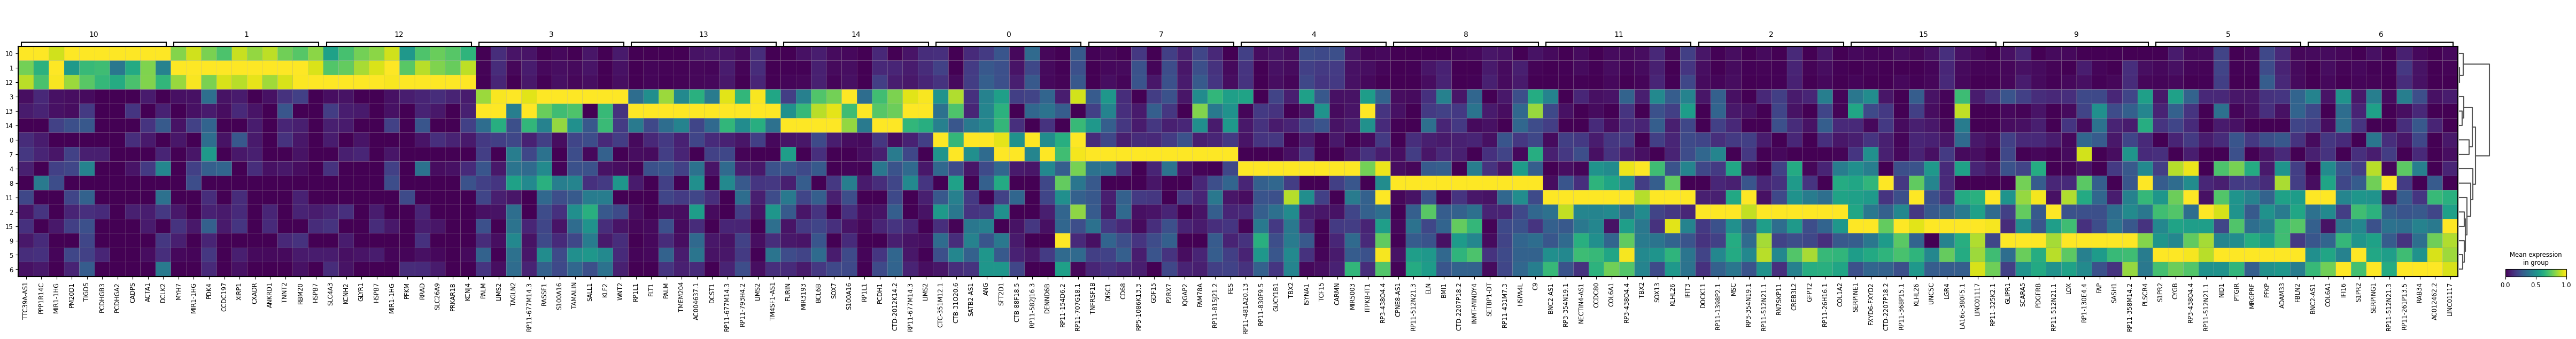

Tables of cell type annotation with clustering kmeans_16 and marker list two_column:


Cluster 2  Score  Hits  Number of marker genes  Mean of UI  \
0                Fibroblasts      5    51                     176           1   
1                  Tanycytes      3     9                      26           1   
2                 Adipocytes      3    29                     121           1   
3  Pancreatic stellate cells      2    11                      29           1   
4     Hepatic stellate cells      2    17                      45           1   

   Normalized Diff  Scaled Diff  
0         0.400000           40  
1         0.000000            0  
2         0.333333           33  
3         0.000000            0  
4         0.000000            0

Cluster 8  Score  Hits  Number of marker genes  Mean of UI  \
0                  Pericytes      2    20                      62           1   
1                Fibroblasts      2    42                     176           1   
2  Pancreatic stellate cells      1    10                      29           1   
3     Hepatic stellate cells      1    14                      45           1   
4    Peritubular myoid cells      1     8                      26           1   

   Normalized Diff  Scaled Diff  
0              0.0            0  
1              0.5           50  
2              0.0            0  
3              0.0            0  
4              0.0            0

Cluster 12  Score  Hits  Number of marker genes  Mean of UI  \
0       Cardiomyocytes     39    59                     107           1   
1             Myocytes     19    32                      89           1   
2  Smooth muscle cells     16    28                      81           1   
3              Neurons     15    58                     205           1   
4      Enteric neurons     13    23                      68           1   

   Normalized Diff  Scaled Diff  
0         0.512821          100  
1         0.157895           31  
2         0.062500           12  
3         0.133333           26  
4         0.000000            0

Cluster 15  Score  Hits  Number of marker genes  Mean of UI  \
0     Hepatic stellate cells      4    15                      45           1   
1                Fibroblasts      4    50                     176           1   
2  Pancreatic stellate cells      3    11                      29           1   
3            Mesangial cells      3    17                      59           1   
4                  Pericytes      3    16                      62           1   

   Normalized Diff  Scaled Diff  
0             0.00            0  
1             0.25           25  
2             0.00            0  
3             0.00            0  
4             0.00            0

Cluster 5  Score  Hits  Number of marker genes  Mean of UI  \
0                Fibroblasts     18    71                     176           1   
1  Pancreatic stellate cells     14    16                      29           1   
2     Hepatic stellate cells     14    23                      45           1   
3                  Pericytes     11    23                      62           1   
4                 Adipocytes     11    40                     121           1   

   Normalized Diff  Scaled Diff  
0         0.222222           22  
1         0.000000            0  
2         0.214286           21  
3         0.000000            0  
4         0.090909            9

Cluster 1  Score  Hits  Number of marker genes  Mean of UI  \
0       Cardiomyocytes     22    58                     107           1   
1             Myocytes     11    30                      89           1   
2  Smooth muscle cells      9    26                      81           1   
3              Neurons      8    53                     205           1   
4      Enteric neurons      7    20                      68           1   

   Normalized Diff  Scaled Diff  
0         0.500000          100  
1         0.181818           36  
2         0.111111           22  
3         0.125000           25  
4         0.000000            0

Cluster 11  Score  Hits  Number of marker genes  \
0                      Fibroblasts      4    51                     176   
1        Pancreatic stellate cells      3    12                      29   
2           Hepatic stellate cells      3    18                      45   
3       Adipocyte progenitor cells      2     8                      24   
4  Pulmonary alveolar type I cells      2    10                      35   

   Mean of UI  Normalized Diff  Scaled Diff  
0           1         0.250000           25  
1           1         0.000000            0  
2           1         0.333333           33  
3           1         0.000000            0  
4           1         0.000000            0

Cluster 6  Score  Hits  Number of marker genes  Mean of UI  \
0                Fibroblasts      6    59                     176           1   
1  Pancreatic stellate cells      5    15                      29           1   
2     Hepatic stellate cells      4    16                      45           1   
3  Endothelial cells (aorta)      3    28                      89           1   
4                  Pericytes      3    19                      62           1   

   Normalized Diff  Scaled Diff  
0         0.166667           17  
1         0.200000           20  
2         0.250000           25  
3         0.000000            0  
4         0.000000            0

Cluster 4  Score  Hits  Number of marker genes  Mean of UI  \
0     Hepatic stellate cells      6    22                      45           1   
1            Mesangial cells      6    23                      59           1   
2                  Pericytes      6    21                      62           1   
3  Pancreatic stellate cells      5    11                      29           1   
4                Fibroblasts      5    46                     176           1   

   Normalized Diff  Scaled Diff  
0         0.000000            0  
1         0.000000            0  
2         0.166667           17  
3         0.000000            0  
4         0.000000            0

Cluster 14  Score  Hits  Number of marker genes  Mean of UI  \
0          Endothelial cells      3    38                     194           1   
1  Endothelial cells (aorta)      2    22                      89           1   
2                  Platelets      2    24                     131           1   
3                Fibroblasts      2    30                     176           1   
4            Transient cells      1     5                      22           1   

   Normalized Diff  Scaled Diff  
0         0.333333           33  
1         0.000000            0  
2         0.000000            0  
3         0.500000           50  
4         0.000000            0

Cluster 13  Score  Hits  Number of marker genes  Mean of UI  \
0          Endothelial cells      5    48                     194           1   
1  Endothelial cells (aorta)      4    28                      89           1   
2              Stromal cells      3    14                      36           1   
3                  Platelets      3    27                     131           1   
4                Fibroblasts      3    36                     176           1   

   Normalized Diff  Scaled Diff  
0         0.200000           20  
1         0.250000           25  
2         0.000000            0  
3         0.000000            0  
4         0.333333           33

Cluster 9  Score  Hits  Number of marker genes  Mean of UI  \
0                Fibroblasts      5    48                     176           1   
1  Pancreatic stellate cells      4    13                      29           1   
2     Hepatic stellate cells      3    20                      45           1   
3                  Pericytes      3    17                      62           1   
4                 Adipocytes      3    27                     121           1   

   Normalized Diff  Scaled Diff  
0         0.200000           20  
1         0.250000           25  
2         0.000000            0  
3         0.000000            0  
4         0.333333           33

Cluster 3  Score  Hits  Number of marker genes  \
0                Endothelial cells      6    53                     194   
1                      Fibroblasts      5    38                     176   
2        Endothelial cells (aorta)      4    24                      89   
3                        Platelets      4    27                     131   
4  Pulmonary alveolar type I cells      3    14                      35   

   Mean of UI  Normalized Diff  Scaled Diff  
0           1         0.166667           17  
1           1         0.200000           20  
2           1         0.000000            0  
3           1         0.250000           25  
4           1         0.000000            0

Cluster 7  Score  Hits  Number of marker genes  Mean of UI  \
0               Osteoclasts      3    11                      52           1   
1  Hematopoietic stem cells      3    15                      91           1   
2               Macrophages      3    21                     134           1   
3                 Microglia      3    11                      72           1   
4                 Monocytes      3    10                     103           1   

   Normalized Diff  Scaled Diff  
0         0.000000            0  
1         0.000000            0  
2         0.000000            0  
3         0.000000            0  
4         0.333333           33

Cluster 10  Score  Hits  \
0                           Cardiomyocytes      6    47   
1                                 Myocytes      3    22   
2  Endothelial cells (blood brain barrier)      2     7   
3                        Radial glia cells      2     5   
4                          Meningeal cells      2     6   

   Number of marker genes  Mean of UI  Normalized Diff  Scaled Diff  
0                     107           1         0.500000           50  
1                      89           1         0.333333           33  
2                      18           1         0.000000            0  
3                      14           1         0.000000            0  
4                      18           1         0.000000            0

Cluster 0  Score  Hits  Number of marker genes  \
0                   Ciliated cells      1     4                      15   
1                    Stromal cells      1     9                      36   
2  Pulmonary alveolar type I cells      1     7                      35   
3           Hepatic stellate cells      1     9                      45   
4                        Pericytes      1    10                      62   

   Mean of UI  Normalized Diff  Scaled Diff  
0           1              0.0            0  
1           1              0.0            0  
2           1              0.0            0  
3           1              0.0            0  
4           1              0.0            0

/home/stud4/.conda/envs/marker-repo-sort/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


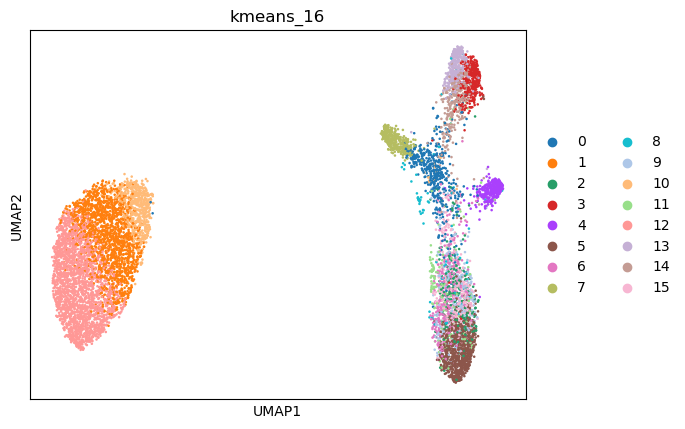

Comparison of cell type annotations:


mr_two_column
kmeans_16                        
0                  Ciliated cells
1                  Cardiomyocytes
2                     Fibroblasts
3               Endothelial cells
4          Hepatic stellate cells
5                     Fibroblasts
6                     Fibroblasts
7                     Osteoclasts
8                       Pericytes
9                     Fibroblasts
10                 Cardiomyocytes
11                    Fibroblasts
12                 Cardiomyocytes
13              Endothelial cells
14              Endothelial cells
15         Hepatic stellate cells

Cluster 2  Score  Hits  Number of marker genes  Mean of UI  \
0                Fibroblasts      5    51                     176           1   
1                  Tanycytes      3     9                      26           1   
2                 Adipocytes      3    29                     121           1   
3  Pancreatic stellate cells      2    11                      29           1   
4     Hepatic stellate cells      2    17                      45           1   

   Normalized Diff  Scaled Diff  
0         0.400000           40  
1         0.000000            0  
2         0.333333           33  
3         0.000000            0  
4         0.000000            0

Cluster 8  Score  Hits  Number of marker genes  Mean of UI  \
0                  Pericytes      2    20                      62           1   
1                Fibroblasts      2    42                     176           1   
2  Pancreatic stellate cells      1    10                      29           1   
3     Hepatic stellate cells      1    14                      45           1   
4    Peritubular myoid cells      1     8                      26           1   

   Normalized Diff  Scaled Diff  
0              0.0            0  
1              0.5           50  
2              0.0            0  
3              0.0            0  
4              0.0            0

Cluster 12  Score  Hits  Number of marker genes  Mean of UI  \
0       Cardiomyocytes     39    59                     107           1   
1             Myocytes     19    32                      89           1   
2  Smooth muscle cells     16    28                      81           1   
3              Neurons     15    58                     205           1   
4      Enteric neurons     13    23                      68           1   

   Normalized Diff  Scaled Diff  
0         0.512821          100  
1         0.157895           31  
2         0.062500           12  
3         0.133333           26  
4         0.000000            0

Cluster 15  Score  Hits  Number of marker genes  Mean of UI  \
0     Hepatic stellate cells      4    15                      45           1   
1                Fibroblasts      4    50                     176           1   
2  Pancreatic stellate cells      3    11                      29           1   
3            Mesangial cells      3    17                      59           1   
4                  Pericytes      3    16                      62           1   

   Normalized Diff  Scaled Diff  
0             0.00            0  
1             0.25           25  
2             0.00            0  
3             0.00            0  
4             0.00            0

Cluster 5  Score  Hits  Number of marker genes  Mean of UI  \
0                Fibroblasts     18    71                     176           1   
1  Pancreatic stellate cells     14    16                      29           1   
2     Hepatic stellate cells     14    23                      45           1   
3                  Pericytes     11    23                      62           1   
4                 Adipocytes     11    40                     121           1   

   Normalized Diff  Scaled Diff  
0         0.222222           22  
1         0.000000            0  
2         0.214286           21  
3         0.000000            0  
4         0.090909            9

Cluster 1  Score  Hits  Number of marker genes  Mean of UI  \
0       Cardiomyocytes     22    58                     107           1   
1             Myocytes     11    30                      89           1   
2  Smooth muscle cells      9    26                      81           1   
3              Neurons      8    53                     205           1   
4      Enteric neurons      7    20                      68           1   

   Normalized Diff  Scaled Diff  
0         0.500000          100  
1         0.181818           36  
2         0.111111           22  
3         0.125000           25  
4         0.000000            0

Cluster 11  Score  Hits  Number of marker genes  \
0                      Fibroblasts      4    51                     176   
1        Pancreatic stellate cells      3    12                      29   
2           Hepatic stellate cells      3    18                      45   
3       Adipocyte progenitor cells      2     8                      24   
4  Pulmonary alveolar type I cells      2    10                      35   

   Mean of UI  Normalized Diff  Scaled Diff  
0           1         0.250000           25  
1           1         0.000000            0  
2           1         0.333333           33  
3           1         0.000000            0  
4           1         0.000000            0

Cluster 6  Score  Hits  Number of marker genes  Mean of UI  \
0                Fibroblasts      6    59                     176           1   
1  Pancreatic stellate cells      5    15                      29           1   
2     Hepatic stellate cells      4    16                      45           1   
3  Endothelial cells (aorta)      3    28                      89           1   
4                  Pericytes      3    19                      62           1   

   Normalized Diff  Scaled Diff  
0         0.166667           17  
1         0.200000           20  
2         0.250000           25  
3         0.000000            0  
4         0.000000            0

Cluster 4  Score  Hits  Number of marker genes  Mean of UI  \
0     Hepatic stellate cells      6    22                      45           1   
1            Mesangial cells      6    23                      59           1   
2                  Pericytes      6    21                      62           1   
3  Pancreatic stellate cells      5    11                      29           1   
4                Fibroblasts      5    46                     176           1   

   Normalized Diff  Scaled Diff  
0         0.000000            0  
1         0.000000            0  
2         0.166667           17  
3         0.000000            0  
4         0.000000            0

Cluster 14  Score  Hits  Number of marker genes  Mean of UI  \
0          Endothelial cells      3    38                     194           1   
1  Endothelial cells (aorta)      2    22                      89           1   
2                  Platelets      2    24                     131           1   
3                Fibroblasts      2    30                     176           1   
4            Transient cells      1     5                      22           1   

   Normalized Diff  Scaled Diff  
0         0.333333           33  
1         0.000000            0  
2         0.000000            0  
3         0.500000           50  
4         0.000000            0

Cluster 13  Score  Hits  Number of marker genes  Mean of UI  \
0          Endothelial cells      5    48                     194           1   
1  Endothelial cells (aorta)      4    28                      89           1   
2              Stromal cells      3    14                      36           1   
3                  Platelets      3    27                     131           1   
4                Fibroblasts      3    36                     176           1   

   Normalized Diff  Scaled Diff  
0         0.200000           20  
1         0.250000           25  
2         0.000000            0  
3         0.000000            0  
4         0.333333           33

Cluster 9  Score  Hits  Number of marker genes  Mean of UI  \
0                Fibroblasts      5    48                     176           1   
1  Pancreatic stellate cells      4    13                      29           1   
2     Hepatic stellate cells      3    20                      45           1   
3                  Pericytes      3    17                      62           1   
4                 Adipocytes      3    27                     121           1   

   Normalized Diff  Scaled Diff  
0         0.200000           20  
1         0.250000           25  
2         0.000000            0  
3         0.000000            0  
4         0.333333           33

Cluster 3  Score  Hits  Number of marker genes  \
0                Endothelial cells      6    53                     194   
1                      Fibroblasts      5    38                     176   
2        Endothelial cells (aorta)      4    24                      89   
3                        Platelets      4    27                     131   
4  Pulmonary alveolar type I cells      3    14                      35   

   Mean of UI  Normalized Diff  Scaled Diff  
0           1         0.166667           17  
1           1         0.200000           20  
2           1         0.000000            0  
3           1         0.250000           25  
4           1         0.000000            0

Cluster 7  Score  Hits  Number of marker genes  Mean of UI  \
0               Osteoclasts      3    11                      52           1   
1  Hematopoietic stem cells      3    15                      91           1   
2               Macrophages      3    21                     134           1   
3                 Microglia      3    11                      72           1   
4                 Monocytes      3    10                     103           1   

   Normalized Diff  Scaled Diff  
0         0.000000            0  
1         0.000000            0  
2         0.000000            0  
3         0.000000            0  
4         0.333333           33

Cluster 10  Score  Hits  \
0                           Cardiomyocytes      6    47   
1                                 Myocytes      3    22   
2  Endothelial cells (blood brain barrier)      2     7   
3                        Radial glia cells      2     5   
4                          Meningeal cells      2     6   

   Number of marker genes  Mean of UI  Normalized Diff  Scaled Diff  
0                     107           1         0.500000           50  
1                      89           1         0.333333           33  
2                      18           1         0.000000            0  
3                      14           1         0.000000            0  
4                      18           1         0.000000            0

Cluster 0  Score  Hits  Number of marker genes  \
0                   Ciliated cells      1     4                      15   
1                    Stromal cells      1     9                      36   
2  Pulmonary alveolar type I cells      1     7                      35   
3           Hepatic stellate cells      1     9                      45   
4                        Pericytes      1    10                      62   

   Mean of UI  Normalized Diff  Scaled Diff  
0           1              0.0            0  
1           1              0.0            0  
2           1              0.0            0  
3           1              0.0            0  
4           1              0.0            0

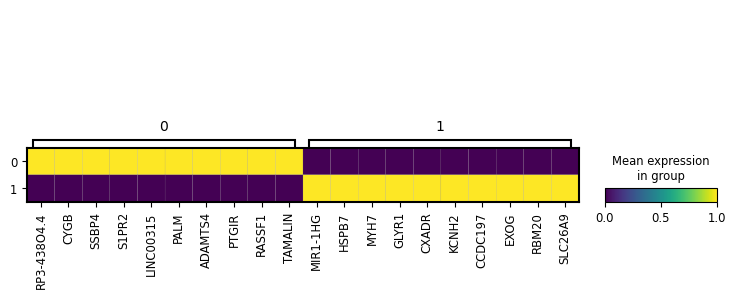

Tables of cell type annotation with clustering leiden_0.1 and marker list two_column:


Cluster 0  Score  Hits  Number of marker genes  Mean of UI  \
0                Fibroblasts     28    61                     176           1   
1     Hepatic stellate cells     23    21                      45           1   
2  Pancreatic stellate cells     22    15                      29           1   
3                  Pericytes     17    20                      62           1   
4                 Adipocytes     16    33                     121           1   

   Normalized Diff  Scaled Diff  
0         0.178571           36  
1         0.043478            9  
2         0.227273           45  
3         0.058824           12  
4         0.000000            0

Cluster 1  Score  Hits  Number of marker genes  Mean of UI  \
0       Cardiomyocytes     61    59                     107           1   
1             Myocytes     29    29                      89           1   
2  Smooth muscle cells     23    27                      81           1   
3              Neurons     21    55                     205           1   
4      Enteric neurons     17    22                      68           1   

   Normalized Diff  Scaled Diff  
0         0.524590          100  
1         0.206897           39  
2         0.086957           17  
3         0.190476           36  
4         0.000000            0

/home/stud4/.conda/envs/marker-repo-sort/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


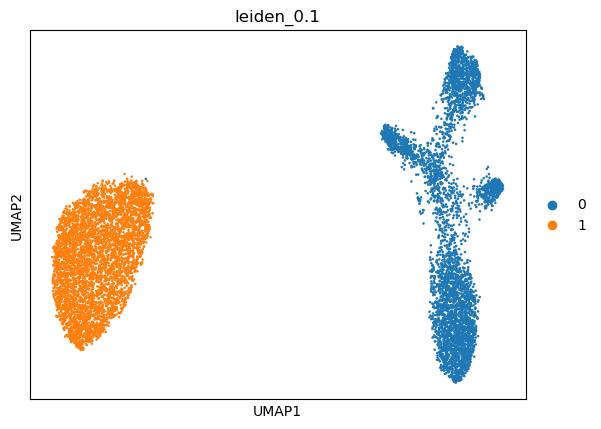

Comparison of cell type annotations:


mr_two_column
leiden_0.1                
0              Fibroblasts
1           Cardiomyocytes

Cluster 0  Score  Hits  Number of marker genes  Mean of UI  \
0                Fibroblasts     28    61                     176           1   
1     Hepatic stellate cells     23    21                      45           1   
2  Pancreatic stellate cells     22    15                      29           1   
3                  Pericytes     17    20                      62           1   
4                 Adipocytes     16    33                     121           1   

   Normalized Diff  Scaled Diff  
0         0.178571           36  
1         0.043478            9  
2         0.227273           45  
3         0.058824           12  
4         0.000000            0

Cluster 1  Score  Hits  Number of marker genes  Mean of UI  \
0       Cardiomyocytes     61    59                     107           1   
1             Myocytes     29    29                      89           1   
2  Smooth muscle cells     23    27                      81           1   
3              Neurons     21    55                     205           1   
4      Enteric neurons     17    22                      68           1   

   Normalized Diff  Scaled Diff  
0         0.524590          100  
1         0.206897           39  
2         0.086957           17  
3         0.190476           36  
4         0.000000            0

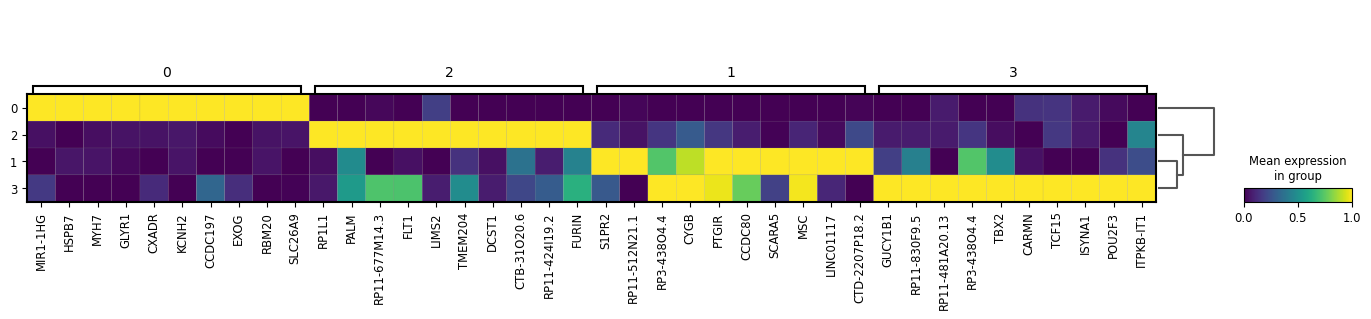

Tables of cell type annotation with clustering leiden_0.25 and marker list two_column:


Cluster 3  Score  Hits  Number of marker genes  Mean of UI  \
0     Hepatic stellate cells      6    22                      45           1   
1            Mesangial cells      6    23                      59           1   
2                  Pericytes      6    21                      62           1   
3  Pancreatic stellate cells      5    12                      29           1   
4                Fibroblasts      5    45                     176           1   

   Normalized Diff  Scaled Diff  
0         0.000000            0  
1         0.000000            0  
2         0.166667           17  
3         0.000000            0  
4         0.000000            0

Cluster 0  Score  Hits  Number of marker genes  Mean of UI  \
0       Cardiomyocytes     61    59                     107           1   
1             Myocytes     29    29                      89           1   
2  Smooth muscle cells     23    27                      81           1   
3              Neurons     21    55                     205           1   
4      Enteric neurons     17    22                      68           1   

   Normalized Diff  Scaled Diff  
0         0.524590          100  
1         0.206897           39  
2         0.086957           17  
3         0.190476           36  
4         0.000000            0

Cluster 2  Score  Hits  Number of marker genes  Mean of UI  \
0          Endothelial cells      7    38                     194           1   
1              Stromal cells      4     8                      36           1   
2  Endothelial cells (aorta)      4    18                      89           1   
3                Fibroblasts      4    31                     176           1   
4                  Platelets      4    22                     131           1   

   Normalized Diff  Scaled Diff  
0         0.428571           43  
1         0.000000            0  
2         0.000000            0  
3         0.000000            0  
4         0.000000            0

Cluster 1  Score  Hits  Number of marker genes  Mean of UI  \
0                Fibroblasts     23    63                     176           1   
1  Pancreatic stellate cells     18    15                      29           1   
2     Hepatic stellate cells     17    21                      45           1   
3                  Pericytes     13    21                      62           1   
4                 Adipocytes     13    37                     121           1   

   Normalized Diff  Scaled Diff  
0         0.217391           43  
1         0.055556           11  
2         0.235294           47  
3         0.000000            0  
4         0.153846           31

/home/stud4/.conda/envs/marker-repo-sort/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


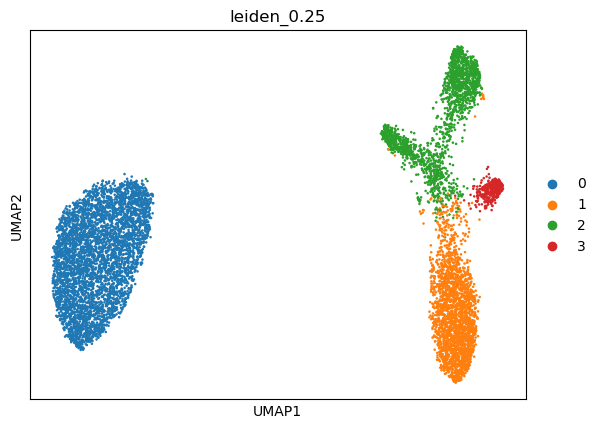

Comparison of cell type annotations:


mr_two_column
leiden_0.25                        
0                    Cardiomyocytes
1                       Fibroblasts
2                 Endothelial cells
3            Hepatic stellate cells

Cluster 3  Score  Hits  Number of marker genes  Mean of UI  \
0     Hepatic stellate cells      6    22                      45           1   
1            Mesangial cells      6    23                      59           1   
2                  Pericytes      6    21                      62           1   
3  Pancreatic stellate cells      5    12                      29           1   
4                Fibroblasts      5    45                     176           1   

   Normalized Diff  Scaled Diff  
0         0.000000            0  
1         0.000000            0  
2         0.166667           17  
3         0.000000            0  
4         0.000000            0

Cluster 0  Score  Hits  Number of marker genes  Mean of UI  \
0       Cardiomyocytes     61    59                     107           1   
1             Myocytes     29    29                      89           1   
2  Smooth muscle cells     23    27                      81           1   
3              Neurons     21    55                     205           1   
4      Enteric neurons     17    22                      68           1   

   Normalized Diff  Scaled Diff  
0         0.524590          100  
1         0.206897           39  
2         0.086957           17  
3         0.190476           36  
4         0.000000            0

Cluster 2  Score  Hits  Number of marker genes  Mean of UI  \
0          Endothelial cells      7    38                     194           1   
1              Stromal cells      4     8                      36           1   
2  Endothelial cells (aorta)      4    18                      89           1   
3                Fibroblasts      4    31                     176           1   
4                  Platelets      4    22                     131           1   

   Normalized Diff  Scaled Diff  
0         0.428571           43  
1         0.000000            0  
2         0.000000            0  
3         0.000000            0  
4         0.000000            0

Cluster 1  Score  Hits  Number of marker genes  Mean of UI  \
0                Fibroblasts     23    63                     176           1   
1  Pancreatic stellate cells     18    15                      29           1   
2     Hepatic stellate cells     17    21                      45           1   
3                  Pericytes     13    21                      62           1   
4                 Adipocytes     13    37                     121           1   

   Normalized Diff  Scaled Diff  
0         0.217391           43  
1         0.055556           11  
2         0.235294           47  
3         0.000000            0  
4         0.153846           31

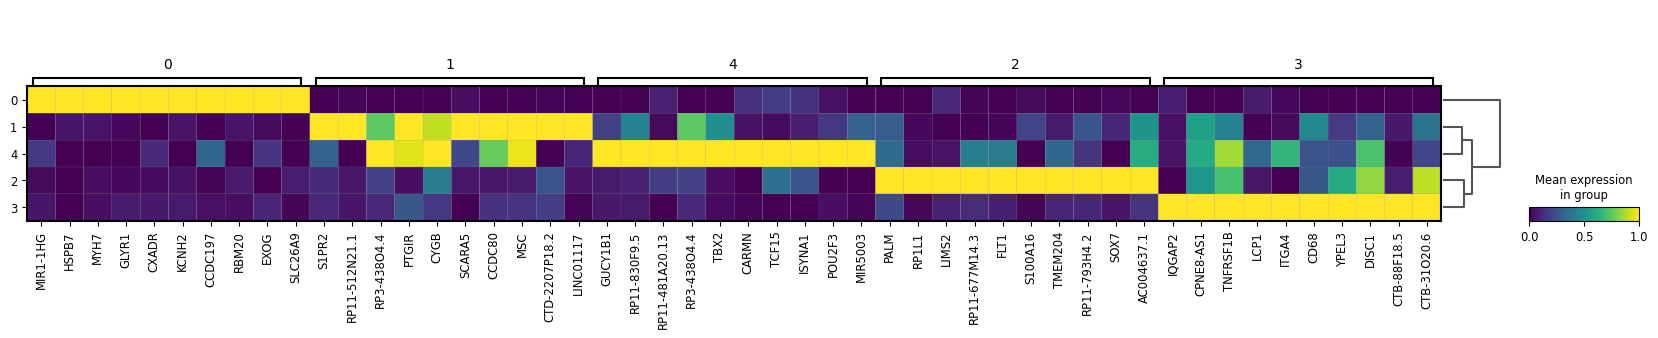

Tables of cell type annotation with clustering leiden_0.5 and marker list two_column:


Cluster 4  Score  Hits  Number of marker genes  Mean of UI  \
0     Hepatic stellate cells      6    22                      45           1   
1            Mesangial cells      6    23                      59           1   
2                  Pericytes      6    21                      62           1   
3  Pancreatic stellate cells      5    12                      29           1   
4                Fibroblasts      5    45                     176           1   

   Normalized Diff  Scaled Diff  
0         0.000000            0  
1         0.000000            0  
2         0.166667           17  
3         0.000000            0  
4         0.000000            0

Cluster 3  Score  Hits  Number of marker genes  Mean of UI  \
0         Ciliated cells      2     4                      15           1   
1            Osteoclasts      2     9                      52           1   
2  Satellite glial cells      2     4                      24           1   
3        Microfold cells      2     5                      30           1   
4          Stromal cells      2     6                      36           1   

   Normalized Diff  Scaled Diff  
0              0.0            0  
1              0.0            0  
2              0.0            0  
3              0.0            0  
4              0.0            0

Cluster 0  Score  Hits  Number of marker genes  Mean of UI  \
0       Cardiomyocytes     61    59                     107           1   
1             Myocytes     29    29                      89           1   
2  Smooth muscle cells     23    27                      81           1   
3              Neurons     21    54                     205           1   
4      Enteric neurons     17    22                      68           1   

   Normalized Diff  Scaled Diff  
0         0.524590          100  
1         0.206897           39  
2         0.086957           17  
3         0.190476           36  
4         0.000000            0

Cluster 2  Score  Hits  Number of marker genes  Mean of UI  \
0          Endothelial cells      9    52                     194           1   
1  Endothelial cells (aorta)      6    26                      89           1   
2                Fibroblasts      5    40                     176           1   
3                  Platelets      5    27                     131           1   
4              Stromal cells      4     9                      36           1   

   Normalized Diff  Scaled Diff  
0         0.333333           67  
1         0.166667           33  
2         0.000000            0  
3         0.200000           40  
4         0.000000            0

Cluster 1  Score  Hits  Number of marker genes  Mean of UI  \
0                Fibroblasts     23    64                     176           1   
1  Pancreatic stellate cells     18    15                      29           1   
2     Hepatic stellate cells     17    21                      45           1   
3                  Pericytes     13    21                      62           1   
4                 Adipocytes     13    36                     121           1   

   Normalized Diff  Scaled Diff  
0         0.217391           43  
1         0.055556           11  
2         0.235294           47  
3         0.000000            0  
4         0.153846           31

/home/stud4/.conda/envs/marker-repo-sort/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


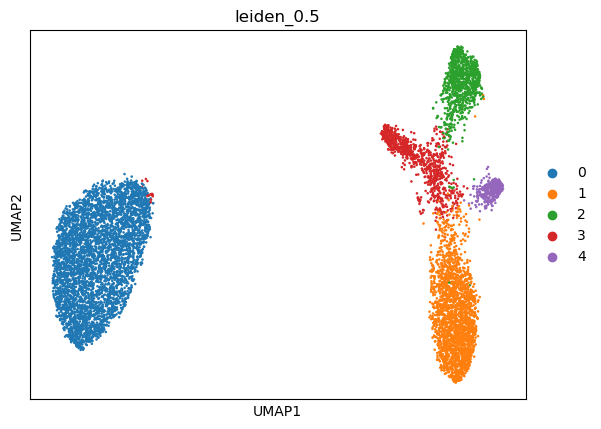

Comparison of cell type annotations:


mr_two_column
leiden_0.5                        
0                   Cardiomyocytes
1                      Fibroblasts
2                Endothelial cells
3                   Ciliated cells
4           Hepatic stellate cells

Cluster 4  Score  Hits  Number of marker genes  Mean of UI  \
0     Hepatic stellate cells      6    22                      45           1   
1            Mesangial cells      6    23                      59           1   
2                  Pericytes      6    21                      62           1   
3  Pancreatic stellate cells      5    12                      29           1   
4                Fibroblasts      5    45                     176           1   

   Normalized Diff  Scaled Diff  
0         0.000000            0  
1         0.000000            0  
2         0.166667           17  
3         0.000000            0  
4         0.000000            0

Cluster 3  Score  Hits  Number of marker genes  Mean of UI  \
0         Ciliated cells      2     4                      15           1   
1            Osteoclasts      2     9                      52           1   
2  Satellite glial cells      2     4                      24           1   
3        Microfold cells      2     5                      30           1   
4          Stromal cells      2     6                      36           1   

   Normalized Diff  Scaled Diff  
0              0.0            0  
1              0.0            0  
2              0.0            0  
3              0.0            0  
4              0.0            0

Cluster 0  Score  Hits  Number of marker genes  Mean of UI  \
0       Cardiomyocytes     61    59                     107           1   
1             Myocytes     29    29                      89           1   
2  Smooth muscle cells     23    27                      81           1   
3              Neurons     21    54                     205           1   
4      Enteric neurons     17    22                      68           1   

   Normalized Diff  Scaled Diff  
0         0.524590          100  
1         0.206897           39  
2         0.086957           17  
3         0.190476           36  
4         0.000000            0

Cluster 2  Score  Hits  Number of marker genes  Mean of UI  \
0          Endothelial cells      9    52                     194           1   
1  Endothelial cells (aorta)      6    26                      89           1   
2                Fibroblasts      5    40                     176           1   
3                  Platelets      5    27                     131           1   
4              Stromal cells      4     9                      36           1   

   Normalized Diff  Scaled Diff  
0         0.333333           67  
1         0.166667           33  
2         0.000000            0  
3         0.200000           40  
4         0.000000            0

Cluster 1  Score  Hits  Number of marker genes  Mean of UI  \
0                Fibroblasts     23    64                     176           1   
1  Pancreatic stellate cells     18    15                      29           1   
2     Hepatic stellate cells     17    21                      45           1   
3                  Pericytes     13    21                      62           1   
4                 Adipocytes     13    36                     121           1   

   Normalized Diff  Scaled Diff  
0         0.217391           43  
1         0.055556           11  
2         0.235294           47  
3         0.000000            0  
4         0.153846           31

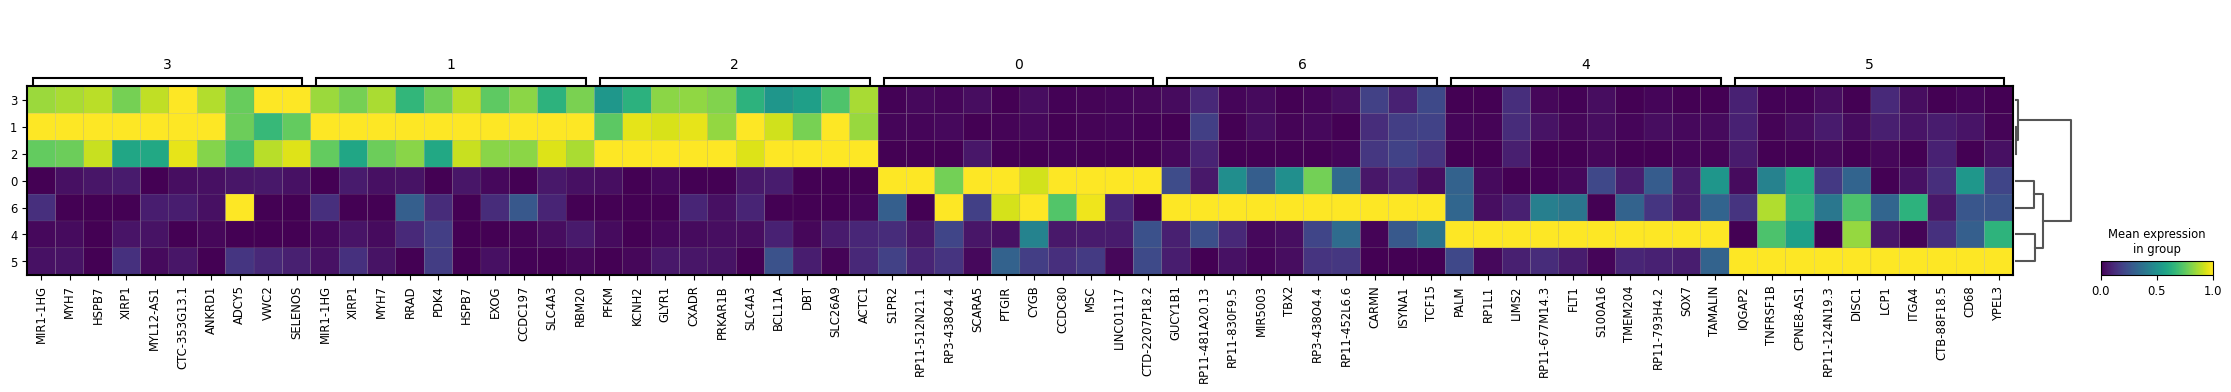

Tables of cell type annotation with clustering leiden_1 and marker list two_column:


Cluster 5  Score  Hits  Number of marker genes  Mean of UI  \
0   Ciliated cells      2     4                      15           1   
1  Microfold cells      2     6                      30           1   
2    Stromal cells      2     7                      36           1   
3      Osteoclasts      2     8                      52           1   
4        Microglia      2    10                      72           1   

   Normalized Diff  Scaled Diff  
0              0.0            0  
1              0.0            0  
2              0.0            0  
3              0.0            0  
4              0.0            0

Cluster 2  Score  Hits  Number of marker genes  Mean of UI  \
0       Cardiomyocytes     28    60                     107           1   
1             Myocytes     14    33                      89           1   
2  Smooth muscle cells     12    27                      81           1   
3              Neurons     10    52                     205           1   
4         Interneurons     10    50                     224           1   

   Normalized Diff  Scaled Diff  
0         0.500000          100  
1         0.142857           29  
2         0.166667           33  
3         0.000000            0  
4         0.100000           20

Cluster 6  Score  Hits  Number of marker genes  Mean of UI  \
0     Hepatic stellate cells      7    21                      45           1   
1            Mesangial cells      6    23                      59           1   
2                  Pericytes      6    21                      62           1   
3  Pancreatic stellate cells      5    12                      29           1   
4                Fibroblasts      5    44                     176           1   

   Normalized Diff  Scaled Diff  
0         0.142857           14  
1         0.000000            0  
2         0.166667           17  
3         0.000000            0  
4         0.000000            0

Cluster 1  Score  Hits  Number of marker genes  \
0              Cardiomyocytes     29    60                     107   
1                    Myocytes     15    32                      89   
2         Smooth muscle cells     12    29                      81   
3                     Neurons     12    64                     205   
4  Olfactory epithelial cells     11    44                     131   

   Mean of UI  Normalized Diff  Scaled Diff  
0           1         0.482759           97  
1           1         0.200000           40  
2           1         0.000000            0  
3           1         0.083333           17  
4           1         0.090909           18

Cluster 3  Score  Hits  \
0                           Cardiomyocytes     13    53   
1                                 Myocytes      6    23   
2                      Smooth muscle cells      4    20   
3                                  Neurons      4    43   
4  Endothelial cells (blood brain barrier)      3     8   

   Number of marker genes  Mean of UI  Normalized Diff  Scaled Diff  
0                     107           1         0.538462           54  
1                      89           1         0.333333           33  
2                      81           1         0.000000            0  
3                     205           1         0.250000           25  
4                      18           1         0.000000            0

Cluster 4  Score  Hits  Number of marker genes  Mean of UI  \
0          Endothelial cells      8    52                     194           1   
1  Endothelial cells (aorta)      6    26                      89           1   
2                Fibroblasts      5    41                     176           1   
3                  Platelets      5    26                     131           1   
4              Stromal cells      4     9                      36           1   

   Normalized Diff  Scaled Diff  
0         0.250000           50  
1         0.166667           33  
2         0.000000            0  
3         0.200000           40  
4         0.000000            0

Cluster 0  Score  Hits  Number of marker genes  Mean of UI  \
0                Fibroblasts     23    64                     176           1   
1  Pancreatic stellate cells     18    15                      29           1   
2     Hepatic stellate cells     17    21                      45           1   
3                  Pericytes     13    21                      62           1   
4                 Adipocytes     13    38                     121           1   

   Normalized Diff  Scaled Diff  
0         0.217391           43  
1         0.055556           11  
2         0.235294           47  
3         0.000000            0  
4         0.153846           31

/home/stud4/.conda/envs/marker-repo-sort/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


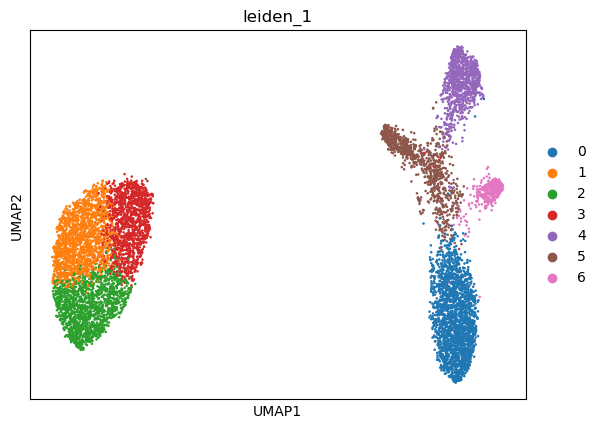

Comparison of cell type annotations:


mr_two_column
leiden_1                        
0                    Fibroblasts
1                 Cardiomyocytes
2                 Cardiomyocytes
3                 Cardiomyocytes
4              Endothelial cells
5                 Ciliated cells
6         Hepatic stellate cells

Cluster 5  Score  Hits  Number of marker genes  Mean of UI  \
0   Ciliated cells      2     4                      15           1   
1  Microfold cells      2     6                      30           1   
2    Stromal cells      2     7                      36           1   
3      Osteoclasts      2     8                      52           1   
4        Microglia      2    10                      72           1   

   Normalized Diff  Scaled Diff  
0              0.0            0  
1              0.0            0  
2              0.0            0  
3              0.0            0  
4              0.0            0

Cluster 2  Score  Hits  Number of marker genes  Mean of UI  \
0       Cardiomyocytes     28    60                     107           1   
1             Myocytes     14    33                      89           1   
2  Smooth muscle cells     12    27                      81           1   
3              Neurons     10    52                     205           1   
4         Interneurons     10    50                     224           1   

   Normalized Diff  Scaled Diff  
0         0.500000          100  
1         0.142857           29  
2         0.166667           33  
3         0.000000            0  
4         0.100000           20

Cluster 6  Score  Hits  Number of marker genes  Mean of UI  \
0     Hepatic stellate cells      7    21                      45           1   
1            Mesangial cells      6    23                      59           1   
2                  Pericytes      6    21                      62           1   
3  Pancreatic stellate cells      5    12                      29           1   
4                Fibroblasts      5    44                     176           1   

   Normalized Diff  Scaled Diff  
0         0.142857           14  
1         0.000000            0  
2         0.166667           17  
3         0.000000            0  
4         0.000000            0

Cluster 1  Score  Hits  Number of marker genes  \
0              Cardiomyocytes     29    60                     107   
1                    Myocytes     15    32                      89   
2         Smooth muscle cells     12    29                      81   
3                     Neurons     12    64                     205   
4  Olfactory epithelial cells     11    44                     131   

   Mean of UI  Normalized Diff  Scaled Diff  
0           1         0.482759           97  
1           1         0.200000           40  
2           1         0.000000            0  
3           1         0.083333           17  
4           1         0.090909           18

Cluster 3  Score  Hits  \
0                           Cardiomyocytes     13    53   
1                                 Myocytes      6    23   
2                      Smooth muscle cells      4    20   
3                                  Neurons      4    43   
4  Endothelial cells (blood brain barrier)      3     8   

   Number of marker genes  Mean of UI  Normalized Diff  Scaled Diff  
0                     107           1         0.538462           54  
1                      89           1         0.333333           33  
2                      81           1         0.000000            0  
3                     205           1         0.250000           25  
4                      18           1         0.000000            0

Cluster 4  Score  Hits  Number of marker genes  Mean of UI  \
0          Endothelial cells      8    52                     194           1   
1  Endothelial cells (aorta)      6    26                      89           1   
2                Fibroblasts      5    41                     176           1   
3                  Platelets      5    26                     131           1   
4              Stromal cells      4     9                      36           1   

   Normalized Diff  Scaled Diff  
0         0.250000           50  
1         0.166667           33  
2         0.000000            0  
3         0.200000           40  
4         0.000000            0

Cluster 0  Score  Hits  Number of marker genes  Mean of UI  \
0                Fibroblasts     23    64                     176           1   
1  Pancreatic stellate cells     18    15                      29           1   
2     Hepatic stellate cells     17    21                      45           1   
3                  Pericytes     13    21                      62           1   
4                 Adipocytes     13    38                     121           1   

   Normalized Diff  Scaled Diff  
0         0.217391           43  
1         0.055556           11  
2         0.235294           47  
3         0.000000            0  
4         0.153846           31

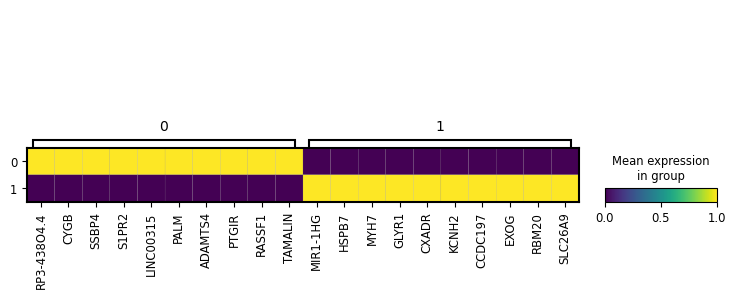

Tables of cell type annotation with clustering lovain_0.1 and marker list two_column:


Cluster 1  Score  Hits  Number of marker genes  Mean of UI  \
0       Cardiomyocytes     61    59                     107           1   
1             Myocytes     29    29                      89           1   
2  Smooth muscle cells     23    27                      81           1   
3              Neurons     21    55                     205           1   
4      Enteric neurons     17    22                      68           1   

   Normalized Diff  Scaled Diff  
0         0.524590          100  
1         0.206897           39  
2         0.086957           17  
3         0.190476           36  
4         0.000000            0

Cluster 0  Score  Hits  Number of marker genes  Mean of UI  \
0                Fibroblasts     28    61                     176           1   
1     Hepatic stellate cells     23    21                      45           1   
2  Pancreatic stellate cells     22    15                      29           1   
3                  Pericytes     17    20                      62           1   
4                 Adipocytes     16    34                     121           1   

   Normalized Diff  Scaled Diff  
0         0.178571           36  
1         0.043478            9  
2         0.227273           45  
3         0.058824           12  
4         0.000000            0

/home/stud4/.conda/envs/marker-repo-sort/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


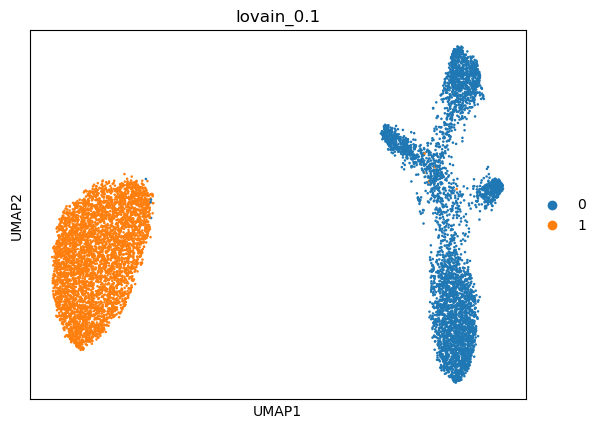

Comparison of cell type annotations:


mr_two_column
lovain_0.1                
0              Fibroblasts
1           Cardiomyocytes

Cluster 1  Score  Hits  Number of marker genes  Mean of UI  \
0       Cardiomyocytes     61    59                     107           1   
1             Myocytes     29    29                      89           1   
2  Smooth muscle cells     23    27                      81           1   
3              Neurons     21    55                     205           1   
4      Enteric neurons     17    22                      68           1   

   Normalized Diff  Scaled Diff  
0         0.524590          100  
1         0.206897           39  
2         0.086957           17  
3         0.190476           36  
4         0.000000            0

Cluster 0  Score  Hits  Number of marker genes  Mean of UI  \
0                Fibroblasts     28    61                     176           1   
1     Hepatic stellate cells     23    21                      45           1   
2  Pancreatic stellate cells     22    15                      29           1   
3                  Pericytes     17    20                      62           1   
4                 Adipocytes     16    34                     121           1   

   Normalized Diff  Scaled Diff  
0         0.178571           36  
1         0.043478            9  
2         0.227273           45  
3         0.058824           12  
4         0.000000            0

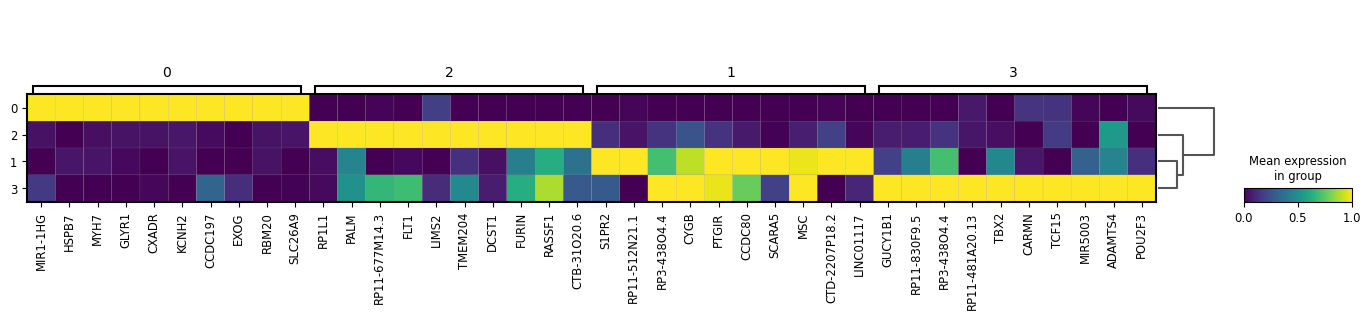

Tables of cell type annotation with clustering lovain_0.25 and marker list two_column:


Cluster 2  Score  Hits  Number of marker genes  Mean of UI  \
0          Endothelial cells      7    40                     194           1   
1  Endothelial cells (aorta)      5    19                      89           1   
2              Stromal cells      4     7                      36           1   
3                  Platelets      4    24                     131           1   
4                Fibroblasts      4    29                     176           1   

   Normalized Diff  Scaled Diff  
0         0.285714           29  
1         0.200000           20  
2         0.000000            0  
3         0.000000            0  
4         0.000000            0

Cluster 1  Score  Hits  Number of marker genes  Mean of UI  \
0                Fibroblasts     23    64                     176           1   
1  Pancreatic stellate cells     18    15                      29           1   
2     Hepatic stellate cells     17    20                      45           1   
3                  Pericytes     13    21                      62           1   
4                 Adipocytes     13    37                     121           1   

   Normalized Diff  Scaled Diff  
0         0.217391           43  
1         0.055556           11  
2         0.235294           47  
3         0.000000            0  
4         0.153846           31

Cluster 3  Score  Hits  Number of marker genes  Mean of UI  \
0     Hepatic stellate cells      6    22                      45           1   
1            Mesangial cells      6    23                      59           1   
2                  Pericytes      6    21                      62           1   
3  Pancreatic stellate cells      5    12                      29           1   
4          Endothelial cells      5    49                     194           1   

   Normalized Diff  Scaled Diff  
0         0.000000            0  
1         0.000000            0  
2         0.166667           17  
3         0.000000            0  
4         0.000000            0

Cluster 0  Score  Hits  Number of marker genes  Mean of UI  \
0       Cardiomyocytes     61    59                     107           1   
1             Myocytes     29    29                      89           1   
2  Smooth muscle cells     23    27                      81           1   
3              Neurons     21    55                     205           1   
4      Enteric neurons     17    22                      68           1   

   Normalized Diff  Scaled Diff  
0         0.524590          100  
1         0.206897           39  
2         0.086957           17  
3         0.190476           36  
4         0.000000            0

/home/stud4/.conda/envs/marker-repo-sort/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


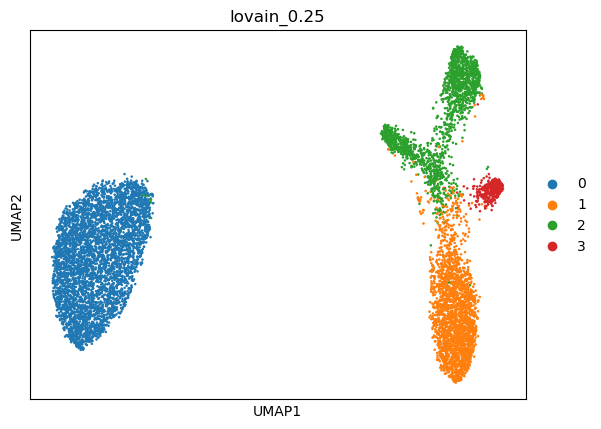

Comparison of cell type annotations:


mr_two_column
lovain_0.25                        
0                    Cardiomyocytes
1                       Fibroblasts
2                 Endothelial cells
3            Hepatic stellate cells

Cluster 2  Score  Hits  Number of marker genes  Mean of UI  \
0          Endothelial cells      7    40                     194           1   
1  Endothelial cells (aorta)      5    19                      89           1   
2              Stromal cells      4     7                      36           1   
3                  Platelets      4    24                     131           1   
4                Fibroblasts      4    29                     176           1   

   Normalized Diff  Scaled Diff  
0         0.285714           29  
1         0.200000           20  
2         0.000000            0  
3         0.000000            0  
4         0.000000            0

Cluster 1  Score  Hits  Number of marker genes  Mean of UI  \
0                Fibroblasts     23    64                     176           1   
1  Pancreatic stellate cells     18    15                      29           1   
2     Hepatic stellate cells     17    20                      45           1   
3                  Pericytes     13    21                      62           1   
4                 Adipocytes     13    37                     121           1   

   Normalized Diff  Scaled Diff  
0         0.217391           43  
1         0.055556           11  
2         0.235294           47  
3         0.000000            0  
4         0.153846           31

Cluster 3  Score  Hits  Number of marker genes  Mean of UI  \
0     Hepatic stellate cells      6    22                      45           1   
1            Mesangial cells      6    23                      59           1   
2                  Pericytes      6    21                      62           1   
3  Pancreatic stellate cells      5    12                      29           1   
4          Endothelial cells      5    49                     194           1   

   Normalized Diff  Scaled Diff  
0         0.000000            0  
1         0.000000            0  
2         0.166667           17  
3         0.000000            0  
4         0.000000            0

Cluster 0  Score  Hits  Number of marker genes  Mean of UI  \
0       Cardiomyocytes     61    59                     107           1   
1             Myocytes     29    29                      89           1   
2  Smooth muscle cells     23    27                      81           1   
3              Neurons     21    55                     205           1   
4      Enteric neurons     17    22                      68           1   

   Normalized Diff  Scaled Diff  
0         0.524590          100  
1         0.206897           39  
2         0.086957           17  
3         0.190476           36  
4         0.000000            0

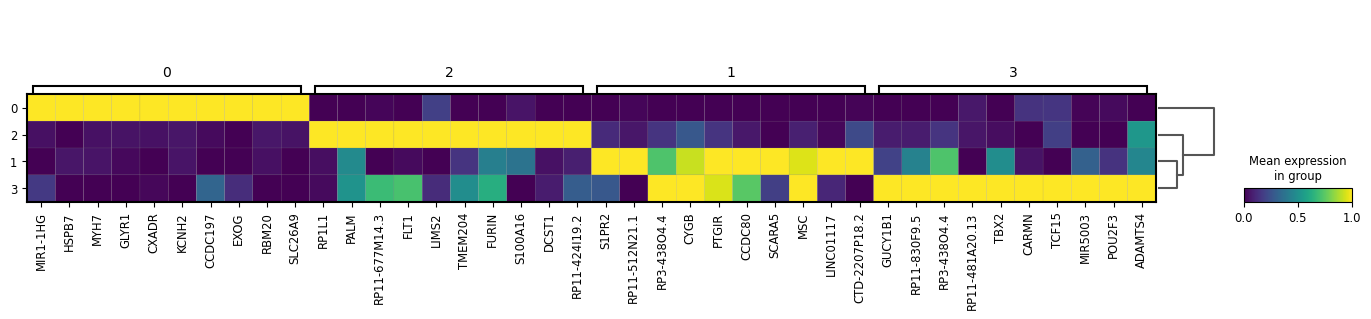

Tables of cell type annotation with clustering lovain_0.5 and marker list two_column:


Cluster 3  Score  Hits  Number of marker genes  Mean of UI  \
0     Hepatic stellate cells      6    22                      45           1   
1            Mesangial cells      6    23                      59           1   
2                  Pericytes      6    21                      62           1   
3  Pancreatic stellate cells      5    12                      29           1   
4                Fibroblasts      5    44                     176           1   

   Normalized Diff  Scaled Diff  
0         0.000000            0  
1         0.000000            0  
2         0.166667           17  
3         0.000000            0  
4         0.000000            0

Cluster 0  Score  Hits  Number of marker genes  Mean of UI  \
0       Cardiomyocytes     61    59                     107           1   
1             Myocytes     29    29                      89           1   
2  Smooth muscle cells     23    27                      81           1   
3              Neurons     21    55                     205           1   
4      Enteric neurons     17    22                      68           1   

   Normalized Diff  Scaled Diff  
0         0.524590          100  
1         0.206897           39  
2         0.086957           17  
3         0.190476           36  
4         0.000000            0

Cluster 2  Score  Hits  Number of marker genes  Mean of UI  \
0          Endothelial cells      7    39                     194           1   
1  Endothelial cells (aorta)      4    18                      89           1   
2              Stromal cells      4     7                      36           1   
3                  Platelets      4    23                     131           1   
4                Fibroblasts      4    29                     176           1   

   Normalized Diff  Scaled Diff  
0         0.428571           43  
1         0.000000            0  
2         0.000000            0  
3         0.000000            0  
4         0.000000            0

Cluster 1  Score  Hits  Number of marker genes  Mean of UI  \
0                Fibroblasts     23    65                     176           1   
1  Pancreatic stellate cells     18    15                      29           1   
2     Hepatic stellate cells     17    21                      45           1   
3                  Pericytes     13    20                      62           1   
4                 Adipocytes     13    37                     121           1   

   Normalized Diff  Scaled Diff  
0         0.217391           43  
1         0.055556           11  
2         0.235294           47  
3         0.000000            0  
4         0.153846           31

/home/stud4/.conda/envs/marker-repo-sort/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


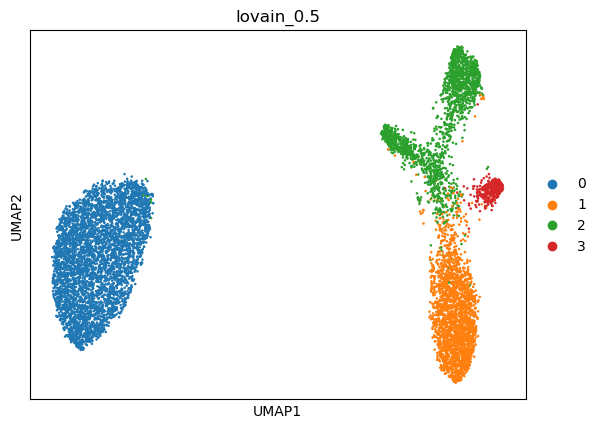

Comparison of cell type annotations:


mr_two_column
lovain_0.5                        
0                   Cardiomyocytes
1                      Fibroblasts
2                Endothelial cells
3           Hepatic stellate cells

Cluster 3  Score  Hits  Number of marker genes  Mean of UI  \
0     Hepatic stellate cells      6    22                      45           1   
1            Mesangial cells      6    23                      59           1   
2                  Pericytes      6    21                      62           1   
3  Pancreatic stellate cells      5    12                      29           1   
4                Fibroblasts      5    44                     176           1   

   Normalized Diff  Scaled Diff  
0         0.000000            0  
1         0.000000            0  
2         0.166667           17  
3         0.000000            0  
4         0.000000            0

Cluster 0  Score  Hits  Number of marker genes  Mean of UI  \
0       Cardiomyocytes     61    59                     107           1   
1             Myocytes     29    29                      89           1   
2  Smooth muscle cells     23    27                      81           1   
3              Neurons     21    55                     205           1   
4      Enteric neurons     17    22                      68           1   

   Normalized Diff  Scaled Diff  
0         0.524590          100  
1         0.206897           39  
2         0.086957           17  
3         0.190476           36  
4         0.000000            0

Cluster 2  Score  Hits  Number of marker genes  Mean of UI  \
0          Endothelial cells      7    39                     194           1   
1  Endothelial cells (aorta)      4    18                      89           1   
2              Stromal cells      4     7                      36           1   
3                  Platelets      4    23                     131           1   
4                Fibroblasts      4    29                     176           1   

   Normalized Diff  Scaled Diff  
0         0.428571           43  
1         0.000000            0  
2         0.000000            0  
3         0.000000            0  
4         0.000000            0

Cluster 1  Score  Hits  Number of marker genes  Mean of UI  \
0                Fibroblasts     23    65                     176           1   
1  Pancreatic stellate cells     18    15                      29           1   
2     Hepatic stellate cells     17    21                      45           1   
3                  Pericytes     13    20                      62           1   
4                 Adipocytes     13    37                     121           1   

   Normalized Diff  Scaled Diff  
0         0.217391           43  
1         0.055556           11  
2         0.235294           47  
3         0.000000            0  
4         0.153846           31

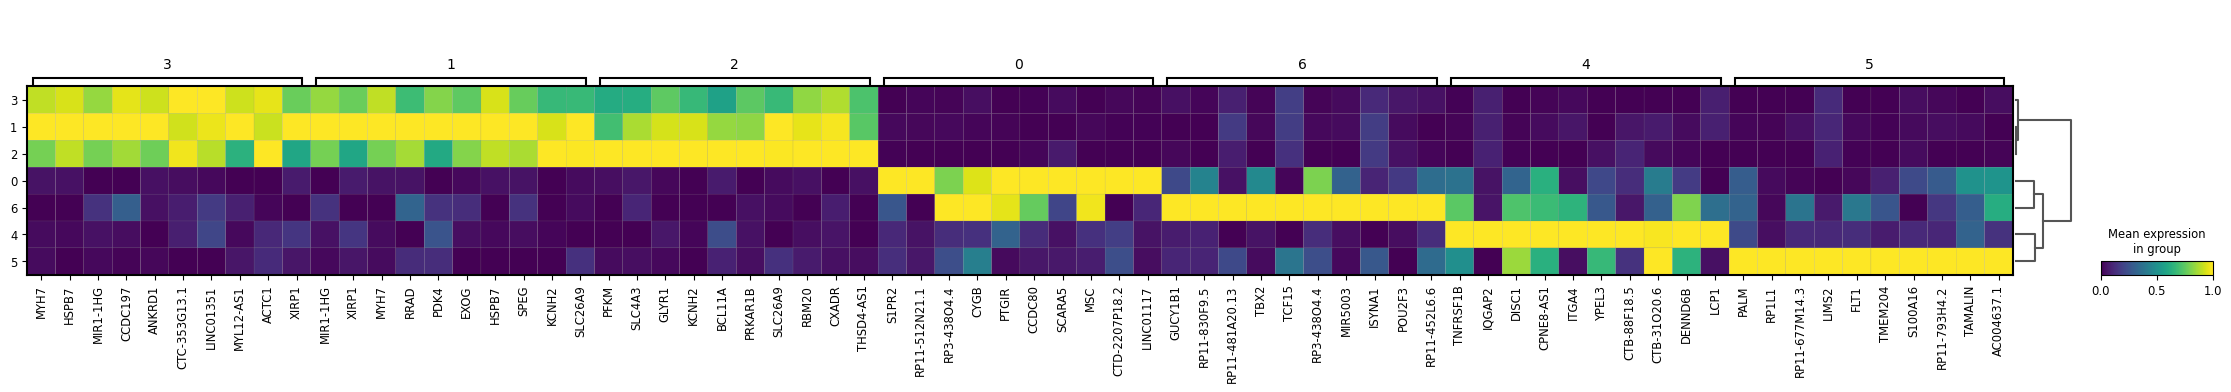

Tables of cell type annotation with clustering lovain_1 and marker list two_column:


Cluster 3  Score  Hits  Number of marker genes  Mean of UI  \
0       Cardiomyocytes     14    54                     107           1   
1             Myocytes      6    23                      89           1   
2  Smooth muscle cells      5    21                      81           1   
3    Radial glia cells      4     6                      14           1   
4      Enteric neurons      4    17                      68           1   

   Normalized Diff  Scaled Diff  
0         0.571429          100  
1         0.166667           29  
2         0.200000           35  
3         0.000000            0  
4         0.000000            0

Cluster 4  Score  Hits  Number of marker genes  Mean of UI  \
0   Ciliated cells      2     4                      15           1   
1  Microfold cells      2     6                      30           1   
2    Stromal cells      2     6                      36           1   
3        Basophils      2    11                      73           1   
4        Microglia      2    10                      72           1   

   Normalized Diff  Scaled Diff  
0              0.0            0  
1              0.0            0  
2              0.0            0  
3              0.0            0  
4              0.0            0

Cluster 0  Score  Hits  Number of marker genes  Mean of UI  \
0                Fibroblasts     23    64                     176           1   
1  Pancreatic stellate cells     18    15                      29           1   
2     Hepatic stellate cells     17    21                      45           1   
3                  Pericytes     13    20                      62           1   
4                 Adipocytes     13    37                     121           1   

   Normalized Diff  Scaled Diff  
0         0.217391           43  
1         0.055556           11  
2         0.235294           47  
3         0.000000            0  
4         0.153846           31

Cluster 5  Score  Hits  Number of marker genes  Mean of UI  \
0          Endothelial cells      8    52                     194           1   
1  Endothelial cells (aorta)      6    29                      89           1   
2                Fibroblasts      5    39                     176           1   
3                  Platelets      5    26                     131           1   
4   Hematopoietic stem cells      4    18                      91           1   

   Normalized Diff  Scaled Diff  
0         0.250000           25  
1         0.166667           17  
2         0.000000            0  
3         0.200000           20  
4         0.250000           25

Cluster 2  Score  Hits  Number of marker genes  Mean of UI  \
0       Cardiomyocytes     28    59                     107           1   
1             Myocytes     14    32                      89           1   
2  Smooth muscle cells     12    27                      81           1   
3              Neurons     11    52                     205           1   
4      Enteric neurons     10    23                      68           1   

   Normalized Diff  Scaled Diff  
0         0.500000          100  
1         0.142857           29  
2         0.083333           17  
3         0.090909           18  
4         0.000000            0

Cluster 6  Score  Hits  Number of marker genes  Mean of UI  \
0     Hepatic stellate cells      6    22                      45           1   
1            Mesangial cells      6    23                      59           1   
2                  Pericytes      6    21                      62           1   
3  Pancreatic stellate cells      5    12                      29           1   
4          Endothelial cells      5    49                     194           1   

   Normalized Diff  Scaled Diff  
0         0.000000            0  
1         0.000000            0  
2         0.166667           17  
3         0.000000            0  
4         0.000000            0

Cluster 1  Score  Hits  Number of marker genes  \
0              Cardiomyocytes     29    60                     107   
1                    Myocytes     14    33                      89   
2         Smooth muscle cells     12    31                      81   
3  Olfactory epithelial cells     11    44                     131   
4                     Neurons     11    60                     205   

   Mean of UI  Normalized Diff  Scaled Diff  
0           1         0.517241          100  
1           1         0.142857           28  
2           1         0.083333           16  
3           1         0.000000            0  
4           1         0.090909           18

/home/stud4/.conda/envs/marker-repo-sort/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


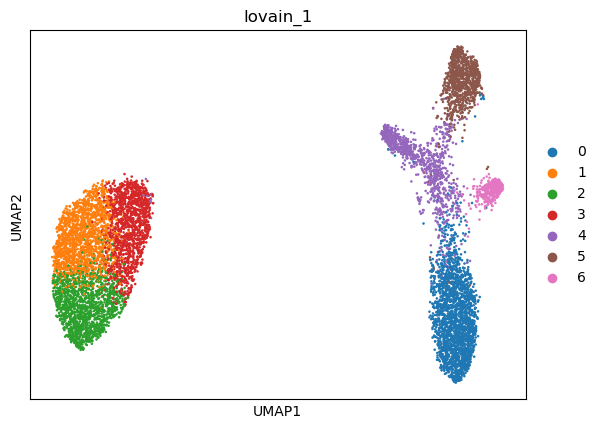

Comparison of cell type annotations:


mr_two_column
lovain_1                        
0                    Fibroblasts
1                 Cardiomyocytes
2                 Cardiomyocytes
3                 Cardiomyocytes
4                 Ciliated cells
5              Endothelial cells
6         Hepatic stellate cells

Cluster 3  Score  Hits  Number of marker genes  Mean of UI  \
0       Cardiomyocytes     14    54                     107           1   
1             Myocytes      6    23                      89           1   
2  Smooth muscle cells      5    21                      81           1   
3    Radial glia cells      4     6                      14           1   
4      Enteric neurons      4    17                      68           1   

   Normalized Diff  Scaled Diff  
0         0.571429          100  
1         0.166667           29  
2         0.200000           35  
3         0.000000            0  
4         0.000000            0

Cluster 4  Score  Hits  Number of marker genes  Mean of UI  \
0   Ciliated cells      2     4                      15           1   
1  Microfold cells      2     6                      30           1   
2    Stromal cells      2     6                      36           1   
3        Basophils      2    11                      73           1   
4        Microglia      2    10                      72           1   

   Normalized Diff  Scaled Diff  
0              0.0            0  
1              0.0            0  
2              0.0            0  
3              0.0            0  
4              0.0            0

Cluster 0  Score  Hits  Number of marker genes  Mean of UI  \
0                Fibroblasts     23    64                     176           1   
1  Pancreatic stellate cells     18    15                      29           1   
2     Hepatic stellate cells     17    21                      45           1   
3                  Pericytes     13    20                      62           1   
4                 Adipocytes     13    37                     121           1   

   Normalized Diff  Scaled Diff  
0         0.217391           43  
1         0.055556           11  
2         0.235294           47  
3         0.000000            0  
4         0.153846           31

Cluster 5  Score  Hits  Number of marker genes  Mean of UI  \
0          Endothelial cells      8    52                     194           1   
1  Endothelial cells (aorta)      6    29                      89           1   
2                Fibroblasts      5    39                     176           1   
3                  Platelets      5    26                     131           1   
4   Hematopoietic stem cells      4    18                      91           1   

   Normalized Diff  Scaled Diff  
0         0.250000           25  
1         0.166667           17  
2         0.000000            0  
3         0.200000           20  
4         0.250000           25

Cluster 2  Score  Hits  Number of marker genes  Mean of UI  \
0       Cardiomyocytes     28    59                     107           1   
1             Myocytes     14    32                      89           1   
2  Smooth muscle cells     12    27                      81           1   
3              Neurons     11    52                     205           1   
4      Enteric neurons     10    23                      68           1   

   Normalized Diff  Scaled Diff  
0         0.500000          100  
1         0.142857           29  
2         0.083333           17  
3         0.090909           18  
4         0.000000            0

Cluster 6  Score  Hits  Number of marker genes  Mean of UI  \
0     Hepatic stellate cells      6    22                      45           1   
1            Mesangial cells      6    23                      59           1   
2                  Pericytes      6    21                      62           1   
3  Pancreatic stellate cells      5    12                      29           1   
4          Endothelial cells      5    49                     194           1   

   Normalized Diff  Scaled Diff  
0         0.000000            0  
1         0.000000            0  
2         0.166667           17  
3         0.000000            0  
4         0.000000            0

Cluster 1  Score  Hits  Number of marker genes  \
0              Cardiomyocytes     29    60                     107   
1                    Myocytes     14    33                      89   
2         Smooth muscle cells     12    31                      81   
3  Olfactory epithelial cells     11    44                     131   
4                     Neurons     11    60                     205   

   Mean of UI  Normalized Diff  Scaled Diff  
0           1         0.517241          100  
1           1         0.142857           28  
2           1         0.083333           16  
3           1         0.000000            0  
4           1         0.090909           18

In [26]:
annotation_df_list = []

for column in clustering_column_lists:
    annotation_df_list.append(run_annotation(adata, SCSA=False, marker_lists=marker_lists, reference_obs=None, show_comparison=True,
                    clustering_column=column, rank_genes_column=rank_genes_column, 
                    ignore_overwrite=True, verbose=False, show_plots=True, show_ct_tables=True, 
                    celltype_column_name=celltype_column_name))

In [68]:
def show_umap_collection(annotation_df_list, clustering_column_lists):
    pattern = r'^([a-zA-Z]+)'
    methodes_dict = {}

    for column in clustering_column_lists:
        isMatch = re.match(pattern, column)
        if isMatch:
            methode = isMatch.group(1)
            if methode in methodes_dict:
                methodes_dict[methode] += 1
            else:
                methodes_dict[methode] = 1 
    
    for methode, num in methodes_dict.items():

        if num == 1:
            plt.imread(f"./figures/umap{methode}")
            plt.show()

        elif num == 2:
            fig, axes = plt.subplots(1, 2, figsize=(15,10))
            count = 0 
            for index, df in enumerate(annotation_df_list):
                if methode in str(df[1]):
                    axes[count].imshow(plt.imread(f"./figures/umap{df[2]}"))
                    axes[count].axis("off")
                    count += 1
            plt.tight_layout()
            plt.show()
        
        elif num > 2:
            row_ = math.ceil(num / 2)
            fig, axes = plt.subplots(row_, 2, figsize=(15,10))
            row = 0
            col = 0
            count = 0
            for index, df in enumerate(annotation_df_list):
                if methode in str(df[1]):
                    axes[row, col].imshow(plt.imread(f"./figures/umap{df[2]}"))
                    axes[row, col].axis("off")
                    count += 1
                    row = count // 2
                    col = count % 2
            plt.tight_layout()
            plt.show()

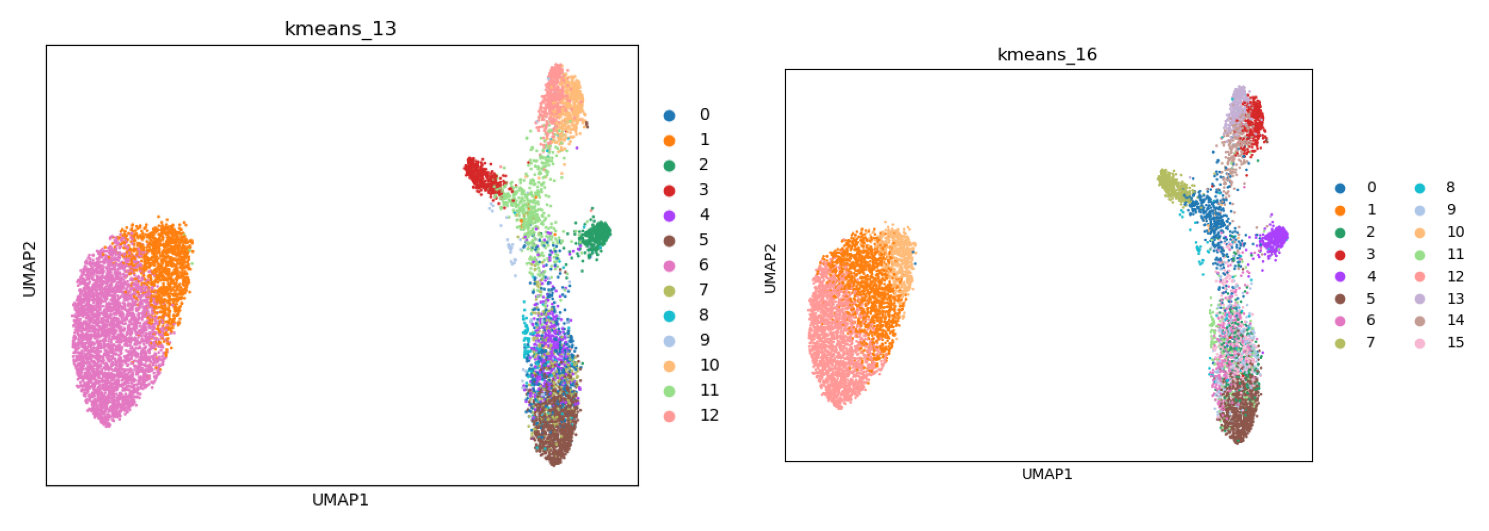

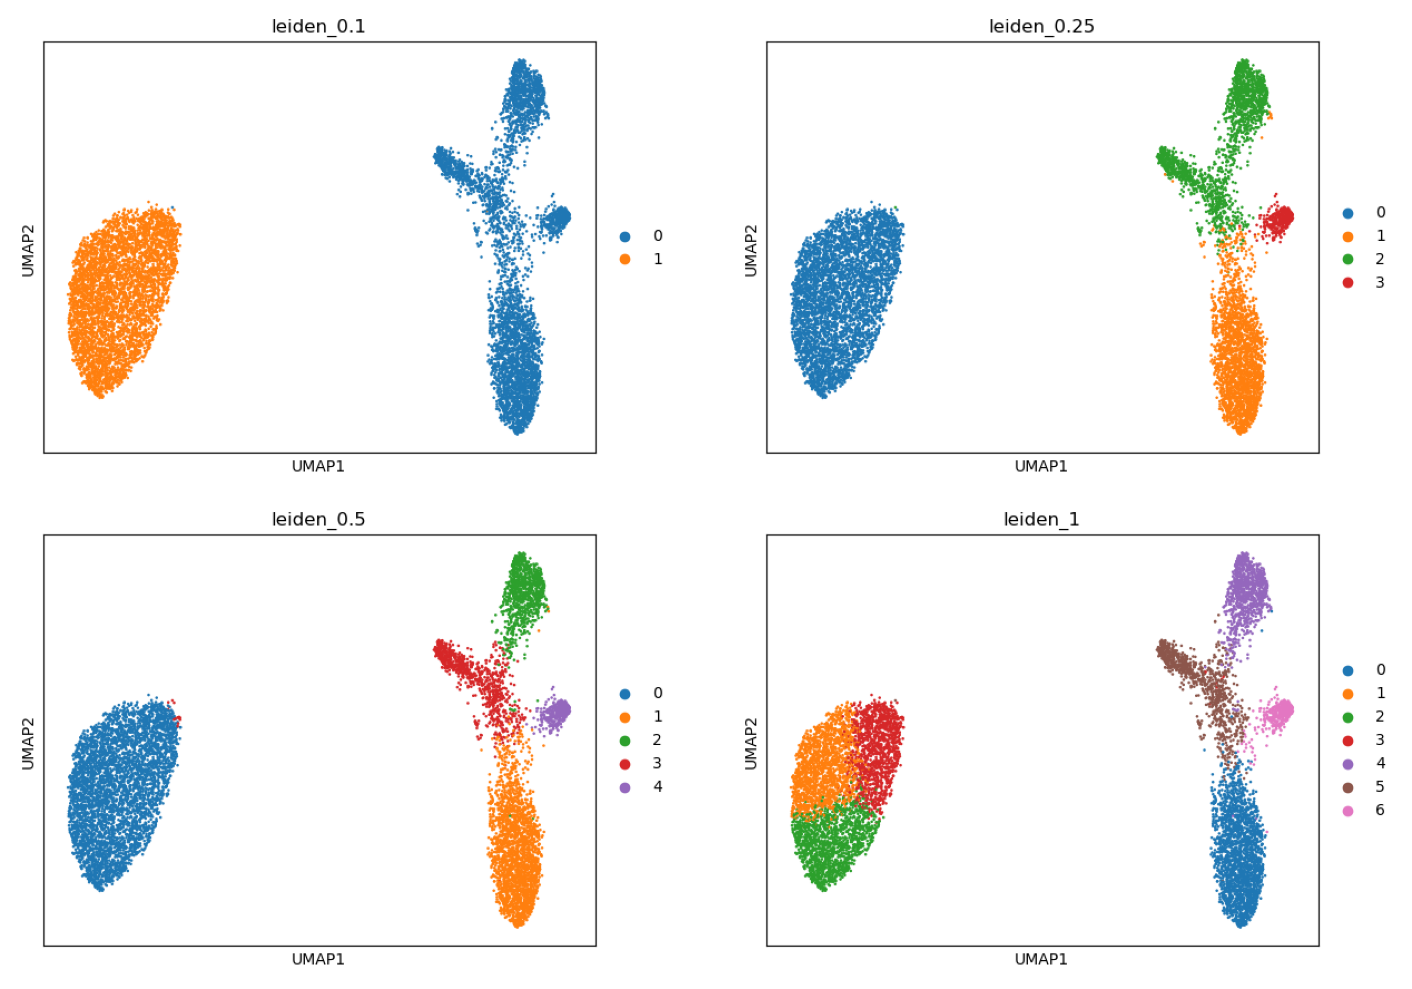

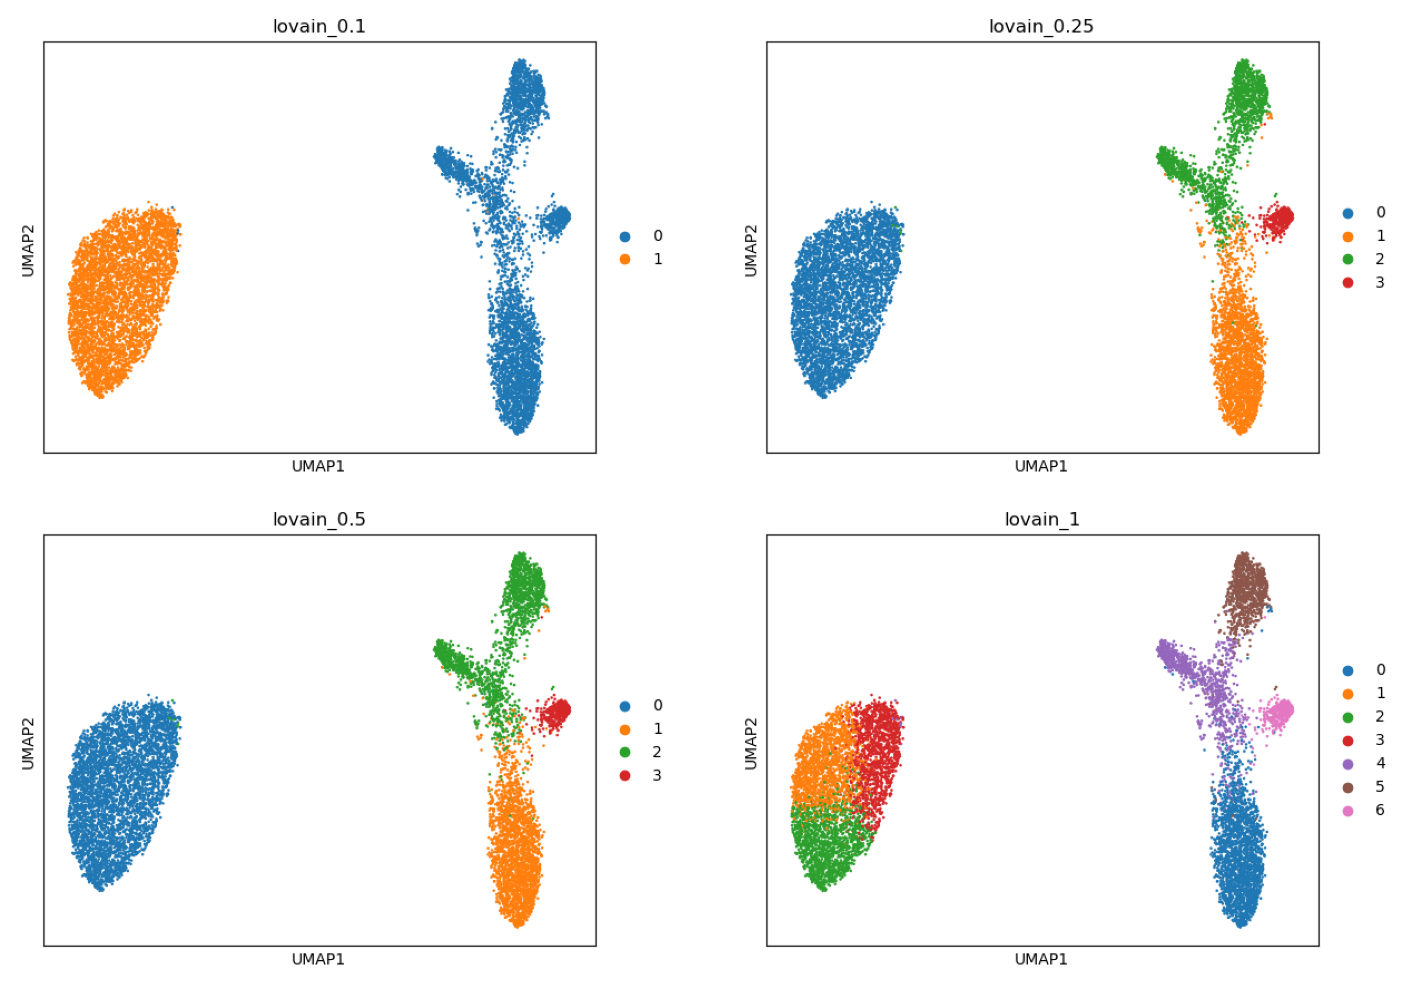

In [69]:
show_umap_collection(annotation_df_list, clustering_column_lists)

In [70]:
def create_compare_df(annotation_df_list):
    cell_types = list(set(value for df in annotation_df_list for value in df[1].iloc[:,0]))
    cell_types.append("ari_score")

    merge_df = pd.DataFrame(columns=clustering_column_lists, index=cell_types)
    merge_df = merge_df.fillna("")

    for data in annotation_df_list:
        col_name = data[0]
        df = data[1]
        for index, value in df.iloc[:,0].iteritems():
            if value in cell_types:
                if not merge_df.at[value, col_name]:
                    merge_df.at[value, col_name] = f"{index}"
                else:
                    merge_df.at[value, col_name] += f", {index}"

    for column in clustering_column_lists:
        merge_df.at["ari_score", column] = round(adata.uns["clusters"][column]["score"]["ari"], 5)

    return merge_df

In [71]:
merge_df = create_compare_df(annotation_df_list)
merge_df

/tmp/ipykernel_119027/1806672712.py:11: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in df.iloc[:,0].iteritems():


kmeans_13       kmeans_16 leiden_0.1 leiden_0.25  \
Pericytes                           9               8                          
Fibroblasts             0, 4, 5, 7, 8  2, 5, 6, 9, 11          0           1   
Cardiomyocytes                   1, 6       1, 10, 12          1           0   
Endothelial cells              10, 12       3, 13, 14                      2   
Osteoclasts                         3               7                          
Stromal cells                      11                                          
Ciliated cells                                      0                          
Hepatic stellate cells              2           4, 15                      3   
ari_score                     0.58538         0.42555    0.64302     0.89282   

                       leiden_0.5 leiden_1 lovain_0.1 lovain_0.25 lovain_0.5  \
Pericytes                                                                      
Fibroblasts                     1        0          0           1          1   
Cardiomyocytes                  0  1, 2, 3          1           0          0   
Endothelial cells               2        4                      2          2   
Osteoclasts                                                                    
Stromal cells                                                                  
Ciliated cells                  3        5                                     
Hepatic stellate cells          4        6                      3          3   
ari_score                 0.92625  0.48619     0.6439     0.89439    0.89031   

                       lovain_1  
Pericytes                        
Fibroblasts                   0  
Cardiomyocytes          1, 2, 3  
Endothelial cells             5  
Osteoclasts                      
Stromal cells                    
Ciliated cells                4  
Hepatic stellate cells        6  
ari_score               0.48629

In [72]:
def find_cluster(methode, cluster_num):
    for df in annotation_df_list:
        if methode == str(df[0]):
            clusters = df[3]
            display(clusters[f"Cluster {cluster_num}"])

In [73]:
find_cluster("lovain_1", 2)

Cluster 2  Score  Hits  Number of marker genes  Mean of UI  \
0       Cardiomyocytes     28    59                     107           1   
1             Myocytes     14    32                      89           1   
2  Smooth muscle cells     12    27                      81           1   
3              Neurons     11    52                     205           1   
4      Enteric neurons     10    23                      68           1   

   Normalized Diff  Scaled Diff  
0         0.500000          100  
1         0.142857           29  
2         0.083333           17  
3         0.090909           18  
4         0.000000            0

In [74]:
best_cluter = str(adata.uns["best_cluster"])
best_cluter

'leiden_0.5'

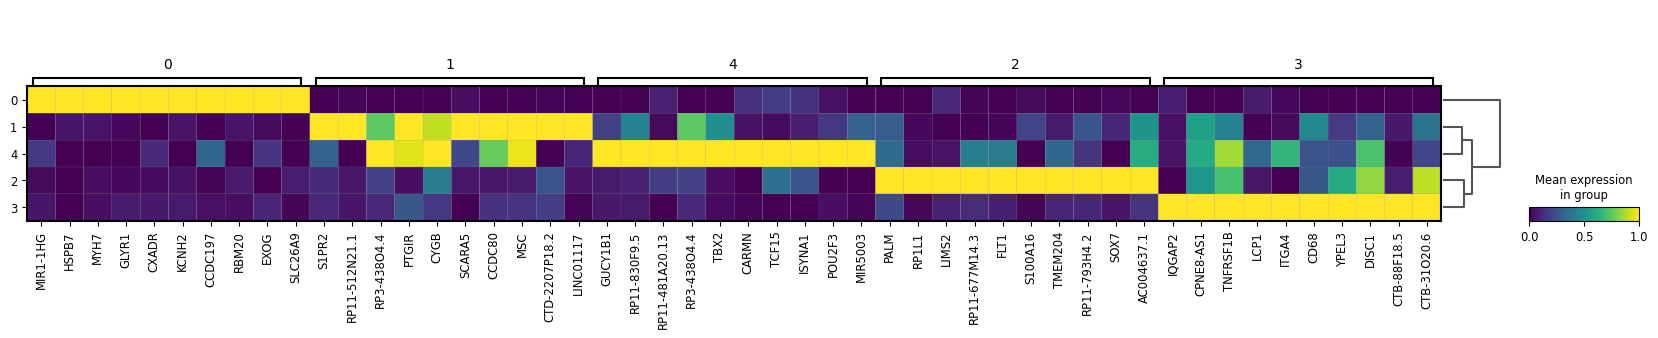

Tables of cell type annotation with clustering leiden_0.5 and marker list two_column:


Cluster 4  Score  Hits  Number of marker genes  Mean of UI  \
0     Hepatic stellate cells      6    22                      45           1   
1            Mesangial cells      6    23                      59           1   
2                  Pericytes      6    21                      62           1   
3  Pancreatic stellate cells      5    12                      29           1   
4                Fibroblasts      5    45                     176           1   

   Adjacent Disparity  
0                   0  
1                   0  
2                  17  
3                   0  
4                   0

Cluster 3  Score  Hits  Number of marker genes  Mean of UI  \
0         Ciliated cells      2     4                      15           1   
1            Osteoclasts      2     9                      52           1   
2  Satellite glial cells      2     4                      24           1   
3        Microfold cells      2     5                      30           1   
4          Stromal cells      2     6                      36           1   

   Adjacent Disparity  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0

Cluster 0  Score  Hits  Number of marker genes  Mean of UI  \
0       Cardiomyocytes     61    59                     107           1   
1             Myocytes     29    29                      89           1   
2  Smooth muscle cells     23    27                      81           1   
3              Neurons     21    54                     205           1   
4      Enteric neurons     17    22                      68           1   

   Adjacent Disparity  
0                 100  
1                  39  
2                  17  
3                  36  
4                   0

Cluster 2  Score  Hits  Number of marker genes  Mean of UI  \
0          Endothelial cells      9    52                     194           1   
1  Endothelial cells (aorta)      6    26                      89           1   
2                Fibroblasts      5    40                     176           1   
3                  Platelets      5    27                     131           1   
4              Stromal cells      4     9                      36           1   

   Adjacent Disparity  
0                  67  
1                  33  
2                   0  
3                  40  
4                   0

Cluster 1  Score  Hits  Number of marker genes  Mean of UI  \
0                Fibroblasts     23    64                     176           1   
1  Pancreatic stellate cells     18    15                      29           1   
2     Hepatic stellate cells     17    21                      45           1   
3                  Pericytes     13    21                      62           1   
4                 Adipocytes     13    36                     121           1   

   Adjacent Disparity  
0                  43  
1                  11  
2                  47  
3                   0  
4                  31

/home/stud4/.conda/envs/marker-repo-sort/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/stud4/.conda/envs/marker-repo-sort/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


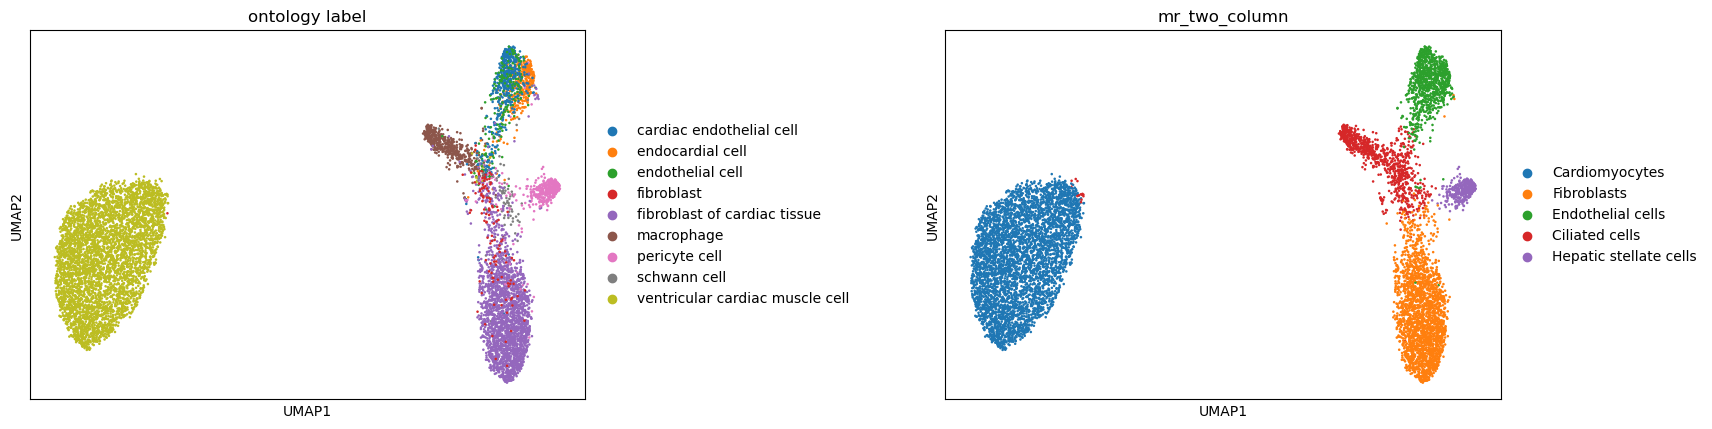

In [75]:
reference_best = wrap.run_annotation(adata, SCSA=False, marker_lists=marker_lists, reference_obs="ontology label", show_comparison=False,
                    clustering_column=best_cluter, rank_genes_column=rank_genes_column, 
                    ignore_overwrite=True, verbose=False, show_plots=True, show_ct_tables=True, 
                    celltype_column_name=celltype_column_name)

Delete created marker lists.

In [76]:
if delete_lists:
    mr.delete_files(marker_lists)

File deleted: /mnt/workspace_stud/stud4/annotate_by_marker_and_features-sort/myCodes/two_column
